# Model 1: Multivariate-3-RNN

## RNN

### Import các thư viện cần thiết

In [1]:
import os
os.environ['PYTHONHASHSEED'] = '0' # đảm bảo rằng các giá trị băm của đối tượng bất biến (dict, set, chuỗi, tuple...) luôn giống nhau giữa các lần chạy

import random as rn
import numpy as np
np.random.seed(1)
rn.seed(3)
import tensorflow as tf
tf.random.set_seed(2)

In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout
from tensorflow.keras import optimizers

In [4]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from math import sqrt
import datetime as dt
import time

from tensorflow.keras.optimizers import Adam

In [5]:
plt.style.use('ggplot')

### Hàm callback

In [6]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')  
checkpoint = ModelCheckpoint(
    filepath="10Var-vn30-rnn.h5",   # Tên file lưu mô hình
    monitor="val_loss",         # Theo dõi val_loss
    save_best_only=True,        # Chỉ lưu khi tốt hơn mô hình trước đó
    mode="min",                 # Giảm min của val_loss là tốt nhất
    verbose=1
)
callbacks_list = [earlystop, checkpoint] 

### Đọc dữ liệu từ file csv

In [ ]:
url = r"VN30 Index.csv"
df = pd.read_csv(url, parse_dates= True, index_col= 0)

In [8]:
print(df.head)

<bound method NDFrame.head of                open     high      low    close       volume
time                                                       
2009-01-05   311.23   311.23   311.23   311.23          NaN
2009-01-06   314.21   314.21   314.21   314.21          NaN
2009-01-07   320.53   320.53   320.53   320.53          NaN
2009-01-08   314.14   314.14   314.14   314.14          NaN
2009-01-09   312.90   312.90   312.90   312.90          NaN
...             ...      ...      ...      ...          ...
2025-03-14  1387.08  1394.39  1385.20  1387.03  374490000.0
2025-03-17  1392.75  1397.28  1389.42  1394.90  352180000.0
2025-03-18  1398.44  1400.38  1388.64  1388.64  291590000.0
2025-03-19  1385.92  1386.57  1374.83  1377.63  363360000.0
2025-03-20  1382.23  1388.37  1371.98  1378.95  359980000.0

[4044 rows x 5 columns]>


In [9]:
print(df.isnull().sum())

open        0
high        0
low         0
close       0
volume    859
dtype: int64


### Tiền xử lí dữ liệu

In [10]:
# Xóa các dòng có giá trị Volume bằng 0
df.drop(df[df['volume']==0].index, inplace=True)

In [11]:
# Ma trận tương quan (ở đây là Pearson tương quan tuyến tính)
df.corr()['close']

open      0.999562
high      0.999783
low       0.999789
close     1.000000
volume    0.169492
Name: close, dtype: float64

In [12]:
#  Tính toán các thống kê mô tả như trung bình (mean), độ lệch chuẩn (std), min, max, phần trăm phân vị (25%, 50%, 75%).
print(df.describe().volume) # Giúp kiểm tra phân bố của Volume, phát hiện các giá trị bất thường (outliers).

count    3.185000e+03
mean     3.279171e+06
std      2.776577e+07
min      4.540000e+03
25%      3.809000e+04
50%      6.036000e+04
75%      1.560100e+05
max      3.744900e+08
Name: volume, dtype: float64


<Axes: >

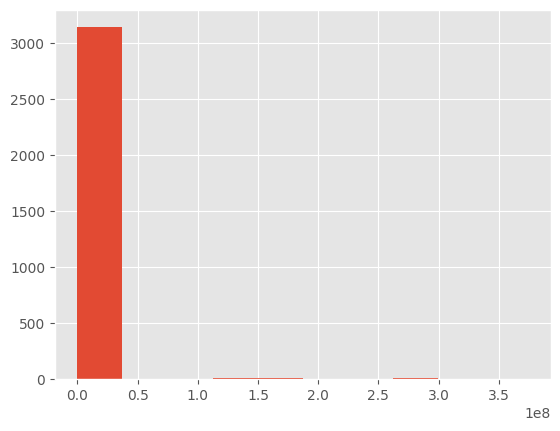

In [13]:
# Vẽ biểu đồ tần suất của Volume
df['volume'].hist(bins=10)

**Phân tích phân bố dữ liệu Volume bằng Histogram**  

🔹 `.hist(bins=10)`  
- Vẽ **biểu đồ histogram** của cột `Volume` với **10 bins (nhóm dữ liệu)**.  
- Giúp trực quan hóa **phân bố dữ liệu**, phát hiện sự **lệch** (skewness) và **giá trị ngoại lai** (outliers).  

**Ý nghĩa của biểu đồ histogram**  

- **Nếu phân bố lệch phải (right-skewed)** → Dữ liệu có nhiều giá trị nhỏ, một số giá trị rất lớn.  
- **Nếu phân bố lệch trái (left-skewed)** → Dữ liệu có nhiều giá trị lớn, một số giá trị rất nhỏ.  
- **Nếu có outliers (điểm nằm xa tập trung chính)** → Có thể cần xử lý như **loại bỏ** hoặc **chuẩn hóa dữ liệu**.  

**Cách xử lý dữ liệu lệch/skewed**  

✅ **Log Transformation** → Dùng `np.log1p(Volume)` để giảm độ lệch.  
✅ **Scaling** → Dùng `MinMaxScaler()` hoặc `StandardScaler()` để chuẩn hóa.  
✅ **Xử lý outliers** → Loại bỏ hoặc thay thế bằng **giá trị trung bình/median**.  


In [18]:
# Bổ sung các chỉ báo kĩ thuật

# Tính CMA10
df['CMA10'] = df['close'].rolling(window=10, center=True).mean()
# Tính SMA10
df['SMA10'] = df['close'].rolling(window=10).mean()
# Tính SMA50
df['SMA50'] = df['close'].rolling(window=50).mean()
# Tính EMA12 và EMA26
df['EMA12'] = df['close'].ewm(span=12, adjust=False).mean()
df['EMA26'] = df['close'].ewm(span=26, adjust=False).mean()
# Tính MACD
df['MACD'] = df['EMA12'] - df['EMA26']
#Tính RSI
# Tính giá tăng/giảm
delta = df['close'].diff()

# Tính giá tăng
gain = delta.where(delta > 0, 0)

# Tính giá giảm
loss = -delta.where(delta < 0, 0)

# Tính trung bình động
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

# Tính RS và RSI
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

#Tính CCI
# Tính giá trung bình
typical_price = (df['high'] + df['low'] + df['close']) / 3

# Tính SMA của giá trung bình
sma_typical_price = typical_price.rolling(window=20).mean()

# Tính độ lệch chuẩn
mean_deviation = typical_price.rolling(window=20).apply(lambda x: np.mean(np.abs(x - x.mean())))

# Tính CCI
df['CCI'] = (typical_price - sma_typical_price) / (0.015 * mean_deviation)
# Tính %K và %D
low_min = df['low'].rolling(window=14).min()
high_max = df['high'].rolling(window=14).max()

df['%K'] = 100 * (df['close'] - low_min) / (high_max - low_min)
df['%D'] = df['%K'].rolling(window=3).mean()

In [20]:
print(df.head())
df.shape

              open    high     low   close  volume  CMA10  SMA10  SMA50  \
time                                                                      
2009-01-05  311.23  311.23  311.23  311.23     NaN    NaN    NaN    NaN   
2009-01-06  314.21  314.21  314.21  314.21     NaN    NaN    NaN    NaN   
2009-01-07  320.53  320.53  320.53  320.53     NaN    NaN    NaN    NaN   
2009-01-08  314.14  314.14  314.14  314.14     NaN    NaN    NaN    NaN   
2009-01-09  312.90  312.90  312.90  312.90     NaN    NaN    NaN    NaN   

                 EMA12       EMA26      MACD  RSI  CCI  %K  %D  
time                                                            
2009-01-05  311.230000  311.230000  0.000000  NaN  NaN NaN NaN  
2009-01-06  311.688462  311.450741  0.237721  NaN  NaN NaN NaN  
2009-01-07  313.048698  312.123278  0.925420  NaN  NaN NaN NaN  
2009-01-08  313.216591  312.272665  0.943926  NaN  NaN NaN NaN  
2009-01-09  313.167885  312.319134  0.848750  NaN  NaN NaN NaN  


(4044, 15)

## Train model / Hàm **fit_model_2()**

In [21]:
def fit_model_2(train, val, timesteps, hl, lr, batch, epochs):
    np.random.seed(1)
    tf.random.set_seed(2)
    rn.seed(3)

    X_train = []
    Y_train = []
    X_val = []
    Y_val = []

    # Loop for training data
    for i in range(timesteps, train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)

    # Loop for val data
    for i in range(timesteps, val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val, Y_val = np.array(X_val), np.array(Y_val)

    # Adding Layers to the model
    model = Sequential()
    model.add(SimpleRNN(X_train.shape[2], input_shape = (X_train.shape[1], X_train.shape[2]), activation = 'relu', return_sequences = True))
    for i in range(len(hl)-1):
        model.add(SimpleRNN(hl[i], activation = 'relu', return_sequences = True))
    model.add(SimpleRNN(hl[-1], activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(learning_rate= lr), loss = 'mean_squared_error')

    # Training the data
    history = model.fit(X_train, Y_train, epochs = epochs, batch_size = batch, validation_data = (X_val, Y_val), verbose = 0, shuffle = False, callbacks=callbacks_list)
    for layer in model.layers:
        if isinstance(layer, SimpleRNN):
            layer.reset_states() #Đảm bảo mỗi lần huấn luyện không bị ảnh hưởng bởi trạng thái cũ của LSTM.
    return model, history.history['loss'], history.history['val_loss']

###  Bước 1: Đặt Seed để đảm bảo tính tái lập

Giúp đảm bảo mỗi lần chạy chương trình, các giá trị ngẫu nhiên được tạo ra giống nhau, tránh kết quả huấn luyện thay đổi giữa các lần chạy.

In [ ]:
"""
np.random.seed(1)
tf.random.set_seed(2)
rn.seed(3)
"""

'\nnp.random.seed(1)\ntf.random.set_seed(2)\nrn.seed(3)\n'

### Bước 2: Chuẩn bị dữ liệu huấn luyện (train) và kiểm định (val)

In [ ]:
"""
X_train = []
Y_train = []
X_val = []
Y_val = []

for i in range(timesteps, train.shape[0]):
    X_train.append(train[i-timesteps:i])
    Y_train.append(train[i][0])
X_train, Y_train = np.array(X_train, Y_train)

for i in range(timesteps, val.shape[0]):
    X_val.append(val[i-timesteps:i])
    Y_val.append(val[i][0])
X_val, Y_val = np.array(X_val, Y_val)  
"""

'\nX_train = []\nY_train = []\nX_val = []\nY_val = []\n\nfor i in range(timesteps, train.shape[0]):\n    X_train.append(train[i-timesteps:i])\n    Y_train.append(train[i][0])\nX_train, Y_train = np.array(X_train, Y_train)\n\nfor i in range(timesteps, val.shape[0]):\n    X_val.append(val[i-timesteps:i])\n    Y_val.append(val[i][0])\nX_val, Y_val = np.array(X_val, Y_val)  \n'

### Bước 3: Xây dựng mô hình RNN

In [ ]:
"""
# Xây dựng mô hình RNN
model = Sequential()
model.add(SimpleRNN(X_train.shape[2], input_shape= (X_train.shape[1], X_train.shape[2]), activation='relu', return_sequences= True))
for i in range(len(hl)-1):
    model.add(SimpleRNN(hl[i], activation='relu', return_sequences= True))
model.add(SimpleRNN(hl[-1], activation='relu'))
model.add(Dense(1))
"""

"\n# Xây dựng mô hình RNN\nmodel = Sequential()\nmodel.add(SimpleRNN(X_train.shape[2], input_shape= (X_train.shape[1], X_train.shape[2]), activation='relu', return_sequences= True))\nfor i in range(len(hl)-1):\n    model.add(SimpleRNN(hl[i], activation='relu', return_sequences= True))\nmodel.add(SimpleRNN(hl[-1], activation='relu'))\nmodel.add(Dense(1))\n"

Thêm một lớp **SimpleRNN đầu tiên**:  
-   `X_train.shape[2]`: Số đặc trưng (features).
-   `input_shape = (X_train.shape[1], X_train.shape[2])`: Định dạng đầu vào (timesteps, số đặc trưng).
-   `activation = 'relu'`: Hàm kích hoạt giúp mô hình học phi tuyến tính.
-   `return_sequences = True`: Giữ lại toàn bộ chuỗi đầu ra để sử dụng trong các lớp tiếp theo.

### Bước 4: Biên dịch mô hình

In [ ]:
"""
# Biên dịch
model.compile(optimizer= optimizers.Adam(learning_rate= lr), loss= 'mean_squared_error')
"""

"\n# Biên dịch\nmodel.compile(optimizer= optimizers.Adam(learning_rate= lr), loss= 'mean_squared_error')\n"

### Bước 5: Huấn luyện mô hình

In [ ]:
"""
history = model.fit(X_train, Y_train, epochs = epochs, batch_size = batch, validation_data = (X_val, Y_val), verbose = 0, shuffle = False, callbacks=callbacks_list)
"""

'\nhistory = model.fit(X_train, Y_train, epochs = epochs, batch_size = batch, validation_data = (X_val, Y_val), verbose = 0, shuffle = False, callbacks=callbacks_list)\n'

**Cấu hình huấn luyện mô hình**

🔹 Tham số trong quá trình huấn luyện  

✅ `epochs = epochs` → Số vòng huấn luyện  
✅ `batch_size = batch` → Kích thước batch  
✅ `validation_data = (X_val, Y_val)` → Dữ liệu kiểm định để theo dõi hiệu suất sau mỗi epoch  
✅ `verbose = 0` → Không hiển thị log huấn luyện (có thể đặt `verbose = 1` để xem tiến trình)  
✅ `shuffle = False` → Không xáo trộn dữ liệu (do chuỗi thời gian có tính thứ tự)  
✅ `callbacks = callbacks_list` → Danh sách callback hỗ trợ huấn luyện  

### Bước 6: Đảm bảo trạng thái không bị ảnh hưởng khi huấn luyện nhiều lần

In [ ]:
"""
for layer in model.layers:
    if isinstance(layer, SimpleRNN):
        layer.reset_states()
"""

'\nfor layer in model.layers:\n    if isinstance(layer, SimpleRNN):\n        layer.reset_states()\n'

### Bước 7: Trả về kết quả

In [ ]:
"""
return model, history.history['train_loss'], history.history['val_loss']
"""

"\nreturn model, history.history['train_loss'], history.history['val_loss']\n"

## **Grid Search**: Tìm kiếm siêu tham số tối ưu 

In [22]:
param_grid = {
    'timesteps': [30, 40, 50],
    'hl': [[40, 35]],
    'lr': [1e-3, 1e-4],
    'batch_size': [32, 64],
    'num_epochs': [200, 250]
}

In [23]:
from itertools import product # Tích đề-các
import pandas as pd

# Hàm Grid Search
def grid_search_rnn(train, val, test, param_grid):
# Khởi tạo danh sách lưu kết quả
    results = []
    best_score = float('inf') # Ban đầu được đặt là vô cùng lớn
    best_params = None # Lưu bộ siêu tham số có hiệu suất tốt nhất
# Tạo tất cả các tổ hợp tham số
    all_combinations = list(product(*param_grid.values()))
    param_names = list(param_grid.keys())
# Lặp qua từng tổ hợp tham số
    for combination in all_combinations:
        params = dict(zip(param_names, combination))
        timesteps = params['timesteps']
        hl = params['hl']
        lr = params['lr']
        batch_size = params['batch_size']
        num_epochs = params['num_epochs']

    print(f'Training with param: {params}')
# Huấn luyện với fit.model()
    model, train_loss, val_loss = fit_model_2(train, val, timesteps, hl, lr,  batch_size, num_epochs)
# Đánh giá mô hình với evaluate_model()
    mse, rmse, mape, r2, _, _ = evaluate_model_2(model, test, timesteps)
# Lưu kết quả
    results.append({
        'timesteps': timesteps,
        'hl': hl,
        'lr': lr,
        'batch_size': batch_size,
        'num_epochs': num_epochs,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape,
        'R²': r2
    })
# Cập nhật bộ siêu tham số tốt nhất nếu RMSE cải thiện
    if rmse < best_score:
        best_score = rmse
        best_params = params

# Trả về kết quả
    results_df = pd.DataFrame(results)
    return best_params, best_score, results_df

## Hàm **Evaluate_model_2()**

In [24]:
"""
# Định nghĩa hàm mean_absolute_percentage_error() (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))*100"
    """

'\n# Định nghĩa hàm mean_absolute_percentage_error() (MAPE)\ndef mean_absolute_percentage_error(y_true, y_pred):\n    y_true, y_pred = np.array(y_true), np.array(y_pred)\n    return np.mean(np.abs((y_true - y_pred) / y_true))*100"\n    '

In [26]:
def evaluate_model_2(model, test, timesteps):
    np.random.seed(1)
    tf.random.set_seed(2)
    rn.seed(3)

    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps, test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test, Y_test = np.array(X_test), np.array(Y_test)

    # Evaluate model
    Y_hat = model.predict(X_test)                         #chứa dự đoán của model dựa trên đầu vào x_test
    mse = mean_squared_error(Y_test, Y_hat)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(Y_test, Y_hat)
    r2 = r2_score(Y_test, Y_hat)
    return mse, rmse, mape, r2, Y_test, Y_hat

## Plot chart (vẽ biểu đồ)

In [27]:
# Plotting the predictions
def plot_data_2(Y_test,Y_hat):
    plt.plot(Y_test, c = 'r')
    plt.plot(Y_hat, c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title("Stock Price Prediction using Multivatiate-RNN")
    plt.legend(['Actual','Predicted'], loc = 'lower right')
    plt.show()

In [28]:
# Plotting the training errors: trực quan loss qua các epoch -> thấy qtr học mô hình, xem có overfitting ko
def plot_error(train_loss, val_loss):
    plt.plot(train_loss, c = 'r')
    plt.plot(val_loss, c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Train Loss and Validation Loss Curve')
    plt.legend(['train', 'val'], loc = 'upper right')
    plt.show()

## **Model building**: Xây dựng mô hình

### Bước 1: Trích xuất và trực quan hóa dữ liệu

In [29]:
# Extracting the series
series = df[['close', 'CMA10', 'SMA10', 'SMA50', 'EMA12', 'RSI', 'CCI', '%K', '%D', 'MACD']]
# Drop rows with NaN values
series = series.dropna()

# Display the shape and the tail of the cleaned series
print(series.shape)
print(series.tail())

(3991, 10)
              close     CMA10     SMA10      SMA50        EMA12        RSI  \
time                                                                         
2025-03-10  1391.07  1381.379  1369.467  1336.1956  1368.821086  81.914388   
2025-03-11  1393.57  1384.753  1372.768  1337.6066  1372.628611  80.831758   
2025-03-12  1392.39  1386.820  1375.951  1338.9890  1375.668825  78.354464   
2025-03-13  1387.30  1388.192  1378.319  1339.8854  1377.458236  71.932575   
2025-03-14  1387.03  1388.125  1381.379  1340.7724  1378.930815  67.050447   

                   CCI         %K         %D       MACD  
time                                                     
2025-03-10  186.248408  86.033606  94.302545  14.085059  
2025-03-11  143.873911  88.007313  90.655860  15.015993  
2025-03-12  152.955891  84.673892  86.238270  15.480105  
2025-03-13  121.672693  73.658150  82.113118  15.261273  
2025-03-14   97.327890  73.123391  77.151811  14.894368  


In [30]:
series.describe()

,close,CMA10,SMA10,SMA50,EMA12,RSI,CCI,%K,%D,MACD
count,3991.000000,3991.000000,3991.00000,3991.000000,3991.000000,3991.000000,3991.000000,3991.000000,3991.000000,3991.000000
mean,814.145743,814.003191,812.86794,807.414210,812.591967,54.032542,17.593878,57.339202,57.342557,1.921103
std,321.109578,320.781191,320.75575,319.492655,320.500740,18.541935,110.243542,32.341940,30.423710,13.176084
min,254.820000,261.983000,251.40000,265.341000,252.982926,4.401922,-339.712898,0.000000,0.000000,-60.553670
25%,552.290000,551.247500,550.82900,547.833600,549.926815,40.285656,-70.241516,28.668093,28.989233,-4.653577
50%,673.530000,672.566000,671.65700,656.734400,669.526149,54.411293,32.984730,62.714014,62.491154,1.775423
75%,1056.925000,1058.503000,1057.24600,1057.393900,1058.727874,67.773165,106.763138,87.016932,85.932690,9.299267
max,1572.460000,1543.976000,1543.97600,1524.849800,1541.505267,100.000000,314.013206,100.000000,100.000000,49.008428


### Bước 2: Chia dữ liệu thành các tập Train, Validation, Test

In [35]:
series.shape

(3991, 10)

In [36]:
n = series.shape[0]
val_size =  test_size = int(n * 0.15)
train_size = n - val_size - test_size # Để tránh sai số làm mất dữ liệu

# Chia tập dữ liệu theo thứ tự thời gian
train_data = series.iloc[:train_size].values
val_data = series.iloc[train_size:train_size + val_size].values
test_data = series.iloc[(train_size + val_size):].values
# Kiểm tra kích thước của từng tập
print(train_data.shape, val_data.shape, test_data.shape)

(2795, 10) (598, 10) (598, 10)


### Bước 3: Chuẩn hóa dữ liệu bằng MinMaxScaler

In [37]:
# Normalisation
np.random.seed(1)
tf.random.set_seed(2)
rn.seed(3)

# Chuẩn hóa
sc = MinMaxScaler() # Tạo bộ chuẩn hóa MinMaxScaler
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)

print(train.shape, val.shape, test.shape)

(2795, 10) (598, 10) (598, 10)


### Bước 4: Tìm siêu tham số tốt nhất bằng Grid Search

In [38]:
best_params, best_score, results_df = grid_search_rnn(train, val, test, param_grid)

print(results_df)
print("Best parameters:", best_params)
print("Best RMSE score:", best_score)


Training with param: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss improved from inf to 0.39085, saving model to 10Var-vn30-rnn.h5



Epoch 2: val_loss improved from 0.39085 to 0.10623, saving model to 10Var-vn30-rnn.h5



Epoch 3: val_loss improved from 0.10623 to 0.02741, saving model to 10Var-vn30-rnn.h5



Epoch 4: val_loss improved from 0.02741 to 0.01941, saving model to 10Var-vn30-rnn.h5



Epoch 5: val_loss improved from 0.01941 to 0.01768, saving model to 10Var-vn30-rnn.h5



Epoch 6: val_loss improved from 0.01768 to 0.01545, saving model to 10Var-vn30-rnn.h5



Epoch 7: val_loss improved from 0.01545 to 0.01335, saving model to 10Var-vn30-rnn.h5



Epoch 8: val_loss improved from 0.01335 to 0.01125, saving model to 10Var-vn30-rnn.h5



Epoch 9: val_loss improved from 0.01125 to 0.00910, saving model to 10Var-vn30-rnn.h5



Epoch 10: val_loss improved from 0.00910 to 0.00679, saving model to 10Var-vn30-rnn.h5



Epoch 11: val_loss improved from 0.00679 to 0.00505, saving model to 10Var-vn30-rnn.h5



Epoch 12: val_loss improved from 0.00505 to 0.00417, saving model to 10Var-vn30-rnn.h5



Epoch 13: val_loss improved from 0.00417 to 0.00364, saving model to 10Var-vn30-rnn.h5



Epoch 14: val_loss improved from 0.00364 to 0.00332, saving model to 10Var-vn30-rnn.h5



Epoch 15: val_loss improved from 0.00332 to 0.00307, saving model to 10Var-vn30-rnn.h5



Epoch 16: val_loss improved from 0.00307 to 0.00289, saving model to 10Var-vn30-rnn.h5



Epoch 17: val_loss improved from 0.00289 to 0.00280, saving model to 10Var-vn30-rnn.h5



Epoch 18: val_loss improved from 0.00280 to 0.00276, saving model to 10Var-vn30-rnn.h5



Epoch 19: val_loss did not improve from 0.00276

Epoch 20: val_loss did not improve from 0.00276

Epoch 21: val_loss did not improve from 0.00276

Epoch 22: val_loss did not improve from 0.00276

Epoch 23: val_loss did not improve from 0.00276

Epoch 24: val_loss did not improve from 0.00276

Epoch 25: val_loss did not improve from 0.00276

Epoch 26: val_loss did not improve from 0.00276

Epoch 27: val_loss did not improve from 0.00276

Epoch 28: val_loss did not improve from 0.00276

Epoch 29: val_loss did not improve from 0.00276

Epoch 30: val_loss did not improve from 0.00276

Epoch 31: val_loss did not improve from 0.00276

Epoch 32: val_loss did not improve from 0.00276

Epoch 33: val_loss did not improve from 0.00276

Epoch 34: val_loss did not improve from 0.00276

Epoch 35: val_loss did not improve from 0.00276

Epoch 36: val_loss did not improve from 0.00276

Epoch 37: val_loss did not improve from 0.00276

Epoch 38: val_loss did not improve from 0.00276

Epoch 39: val_loss 


Epoch 75: val_loss improved from 0.00276 to 0.00270, saving model to 10Var-vn30-rnn.h5



Epoch 76: val_loss improved from 0.00270 to 0.00266, saving model to 10Var-vn30-rnn.h5



Epoch 77: val_loss improved from 0.00266 to 0.00261, saving model to 10Var-vn30-rnn.h5



Epoch 78: val_loss improved from 0.00261 to 0.00258, saving model to 10Var-vn30-rnn.h5



Epoch 79: val_loss improved from 0.00258 to 0.00254, saving model to 10Var-vn30-rnn.h5



Epoch 80: val_loss improved from 0.00254 to 0.00252, saving model to 10Var-vn30-rnn.h5



Epoch 81: val_loss improved from 0.00252 to 0.00249, saving model to 10Var-vn30-rnn.h5



Epoch 82: val_loss improved from 0.00249 to 0.00245, saving model to 10Var-vn30-rnn.h5



Epoch 83: val_loss improved from 0.00245 to 0.00242, saving model to 10Var-vn30-rnn.h5



Epoch 84: val_loss improved from 0.00242 to 0.00240, saving model to 10Var-vn30-rnn.h5



Epoch 85: val_loss improved from 0.00240 to 0.00237, saving model to 10Var-vn30-rnn.h5



Epoch 86: val_loss improved from 0.00237 to 0.00236, saving model to 10Var-vn30-rnn.h5



Epoch 87: val_loss improved from 0.00236 to 0.00233, saving model to 10Var-vn30-rnn.h5



Epoch 88: val_loss improved from 0.00233 to 0.00232, saving model to 10Var-vn30-rnn.h5



Epoch 89: val_loss improved from 0.00232 to 0.00229, saving model to 10Var-vn30-rnn.h5



Epoch 90: val_loss improved from 0.00229 to 0.00227, saving model to 10Var-vn30-rnn.h5



Epoch 91: val_loss improved from 0.00227 to 0.00225, saving model to 10Var-vn30-rnn.h5



Epoch 92: val_loss improved from 0.00225 to 0.00223, saving model to 10Var-vn30-rnn.h5



Epoch 93: val_loss improved from 0.00223 to 0.00220, saving model to 10Var-vn30-rnn.h5



Epoch 94: val_loss improved from 0.00220 to 0.00219, saving model to 10Var-vn30-rnn.h5



Epoch 95: val_loss improved from 0.00219 to 0.00216, saving model to 10Var-vn30-rnn.h5



Epoch 96: val_loss improved from 0.00216 to 0.00214, saving model to 10Var-vn30-rnn.h5



Epoch 97: val_loss improved from 0.00214 to 0.00212, saving model to 10Var-vn30-rnn.h5



Epoch 98: val_loss improved from 0.00212 to 0.00208, saving model to 10Var-vn30-rnn.h5



Epoch 99: val_loss improved from 0.00208 to 0.00205, saving model to 10Var-vn30-rnn.h5



Epoch 100: val_loss improved from 0.00205 to 0.00202, saving model to 10Var-vn30-rnn.h5



Epoch 101: val_loss improved from 0.00202 to 0.00200, saving model to 10Var-vn30-rnn.h5



Epoch 102: val_loss improved from 0.00200 to 0.00196, saving model to 10Var-vn30-rnn.h5



Epoch 103: val_loss did not improve from 0.00196

Epoch 104: val_loss improved from 0.00196 to 0.00191, saving model to 10Var-vn30-rnn.h5



Epoch 105: val_loss did not improve from 0.00191

Epoch 106: val_loss improved from 0.00191 to 0.00187, saving model to 10Var-vn30-rnn.h5



Epoch 107: val_loss did not improve from 0.00187

Epoch 108: val_loss improved from 0.00187 to 0.00183, saving model to 10Var-vn30-rnn.h5



Epoch 109: val_loss did not improve from 0.00183

Epoch 110: val_loss improved from 0.00183 to 0.00179, saving model to 10Var-vn30-rnn.h5



Epoch 111: val_loss did not improve from 0.00179

Epoch 112: val_loss improved from 0.00179 to 0.00175, saving model to 10Var-vn30-rnn.h5



Epoch 113: val_loss did not improve from 0.00175

Epoch 114: val_loss improved from 0.00175 to 0.00172, saving model to 10Var-vn30-rnn.h5



Epoch 115: val_loss did not improve from 0.00172

Epoch 116: val_loss improved from 0.00172 to 0.00169, saving model to 10Var-vn30-rnn.h5



Epoch 117: val_loss improved from 0.00169 to 0.00169, saving model to 10Var-vn30-rnn.h5



Epoch 118: val_loss improved from 0.00169 to 0.00166, saving model to 10Var-vn30-rnn.h5



Epoch 119: val_loss did not improve from 0.00166

Epoch 120: val_loss improved from 0.00166 to 0.00163, saving model to 10Var-vn30-rnn.h5



Epoch 121: val_loss did not improve from 0.00163

Epoch 122: val_loss improved from 0.00163 to 0.00162, saving model to 10Var-vn30-rnn.h5



Epoch 123: val_loss improved from 0.00162 to 0.00162, saving model to 10Var-vn30-rnn.h5



Epoch 124: val_loss improved from 0.00162 to 0.00160, saving model to 10Var-vn30-rnn.h5



Epoch 125: val_loss did not improve from 0.00160

Epoch 126: val_loss improved from 0.00160 to 0.00158, saving model to 10Var-vn30-rnn.h5



Epoch 127: val_loss did not improve from 0.00158

Epoch 128: val_loss improved from 0.00158 to 0.00157, saving model to 10Var-vn30-rnn.h5



Epoch 129: val_loss improved from 0.00157 to 0.00156, saving model to 10Var-vn30-rnn.h5



Epoch 130: val_loss improved from 0.00156 to 0.00154, saving model to 10Var-vn30-rnn.h5



Epoch 131: val_loss improved from 0.00154 to 0.00153, saving model to 10Var-vn30-rnn.h5



Epoch 132: val_loss improved from 0.00153 to 0.00150, saving model to 10Var-vn30-rnn.h5



Epoch 133: val_loss improved from 0.00150 to 0.00147, saving model to 10Var-vn30-rnn.h5



Epoch 134: val_loss improved from 0.00147 to 0.00146, saving model to 10Var-vn30-rnn.h5



Epoch 135: val_loss improved from 0.00146 to 0.00143, saving model to 10Var-vn30-rnn.h5



Epoch 136: val_loss improved from 0.00143 to 0.00141, saving model to 10Var-vn30-rnn.h5



Epoch 137: val_loss improved from 0.00141 to 0.00137, saving model to 10Var-vn30-rnn.h5



Epoch 138: val_loss improved from 0.00137 to 0.00135, saving model to 10Var-vn30-rnn.h5



Epoch 139: val_loss improved from 0.00135 to 0.00134, saving model to 10Var-vn30-rnn.h5



Epoch 140: val_loss improved from 0.00134 to 0.00130, saving model to 10Var-vn30-rnn.h5



Epoch 141: val_loss improved from 0.00130 to 0.00129, saving model to 10Var-vn30-rnn.h5



Epoch 142: val_loss improved from 0.00129 to 0.00126, saving model to 10Var-vn30-rnn.h5



Epoch 143: val_loss improved from 0.00126 to 0.00124, saving model to 10Var-vn30-rnn.h5



Epoch 144: val_loss improved from 0.00124 to 0.00122, saving model to 10Var-vn30-rnn.h5



Epoch 145: val_loss improved from 0.00122 to 0.00119, saving model to 10Var-vn30-rnn.h5



Epoch 146: val_loss improved from 0.00119 to 0.00118, saving model to 10Var-vn30-rnn.h5



Epoch 147: val_loss improved from 0.00118 to 0.00118, saving model to 10Var-vn30-rnn.h5



Epoch 148: val_loss did not improve from 0.00118

Epoch 149: val_loss did not improve from 0.00118

Epoch 150: val_loss did not improve from 0.00118

Epoch 151: val_loss did not improve from 0.00118

Epoch 152: val_loss did not improve from 0.00118

Epoch 153: val_loss did not improve from 0.00118

Epoch 154: val_loss did not improve from 0.00118

Epoch 155: val_loss improved from 0.00118 to 0.00104, saving model to 10Var-vn30-rnn.h5



Epoch 156: val_loss did not improve from 0.00104

Epoch 157: val_loss did not improve from 0.00104

Epoch 158: val_loss did not improve from 0.00104

Epoch 159: val_loss did not improve from 0.00104

Epoch 160: val_loss did not improve from 0.00104

Epoch 161: val_loss did not improve from 0.00104

Epoch 162: val_loss did not improve from 0.00104

Epoch 163: val_loss did not improve from 0.00104

Epoch 164: val_loss did not improve from 0.00104

Epoch 165: val_loss did not improve from 0.00104

Epoch 166: val_loss did not improve from 0.00104

Epoch 167: val_loss did not improve from 0.00104

Epoch 168: val_loss did not improve from 0.00104

Epoch 169: val_loss did not improve from 0.00104

Epoch 170: val_loss did not improve from 0.00104

Epoch 171: val_loss did not improve from 0.00104

Epoch 172: val_loss did not improve from 0.00104

Epoch 173: val_loss did not improve from 0.00104

Epoch 174: val_loss did not improve from 0.00104

Epoch 175: val_loss did not improve from 0.00104



Epoch 199: val_loss did not improve from 0.00092

Epoch 200: val_loss did not improve from 0.00092

Epoch 201: val_loss did not improve from 0.00092

Epoch 202: val_loss did not improve from 0.00092

Epoch 203: val_loss did not improve from 0.00092

Epoch 204: val_loss did not improve from 0.00092

Epoch 205: val_loss did not improve from 0.00092

Epoch 206: val_loss did not improve from 0.00092

Epoch 207: val_loss did not improve from 0.00092

Epoch 208: val_loss did not improve from 0.00092

Epoch 209: val_loss did not improve from 0.00092

Epoch 210: val_loss did not improve from 0.00092

Epoch 211: val_loss did not improve from 0.00092

Epoch 212: val_loss did not improve from 0.00092

Epoch 213: val_loss did not improve from 0.00092

Epoch 214: val_loss did not improve from 0.00092

Epoch 215: val_loss did not improve from 0.00092

Epoch 216: val_loss did not improve from 0.00092

Epoch 217: val_loss did not improve from 0.00092

Epoch 218: val_loss did not improve from 0.00092


### Bước 5: Huấn luyện mô hình với bộ tham số tối ưu

In [39]:
timesteps = 50
hl = [40, 35]
lr = 0.0001
batch_size = 64
num_epochs = 250

model, train_error, val_error = fit_model_2(train, val, timesteps, hl, lr, batch_size, num_epochs)

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00092

Epoch 2: val_loss did not improve from 0.00092

Epoch 3: val_loss did not improve from 0.00092

Epoch 4: val_loss did not improve from 0.00092

Epoch 5: val_loss did not improve from 0.00092

Epoch 6: val_loss did not improve from 0.00092

Epoch 7: val_loss did not improve from 0.00092

Epoch 8: val_loss did not improve from 0.00092

Epoch 9: val_loss did not improve from 0.00092

Epoch 10: val_loss did not improve from 0.00092

Epoch 11: val_loss did not improve from 0.00092

Epoch 12: val_loss did not improve from 0.00092

Epoch 13: val_loss did not improve from 0.00092

Epoch 14: val_loss did not improve from 0.00092

Epoch 15: val_loss did not improve from 0.00092

Epoch 16: val_loss did not improve from 0.00092

Epoch 17: val_loss did not improve from 0.00092

Epoch 18: val_loss did not improve from 0.00092

Epoch 19: val_loss did not improve from 0.00092

Epoch 20: val_loss did not improve from 0.00092

Epoch 21: val_loss did not i

### Bước 6: Đánh giá mô hình và trực quan hóa kết quả

#### 6.1. Vẽ biểu đồ train_loss và val_loss

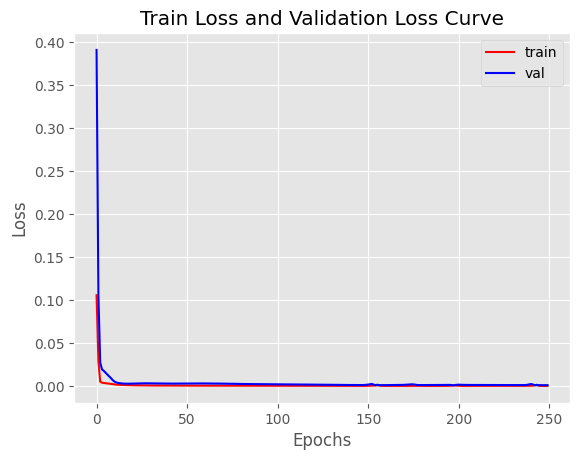

In [40]:
plot_error(train_error, val_error)

#### 6.2. Đánh giá mô hình trên tập test

In [41]:
mse, rmse, mape, r2, true, predicted = evaluate_model_2(model, test, timesteps) #được tính dựa trên bộ dữ liệu đã chuẩn hoá


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


In [42]:
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('MAPE = {}'.format(mape))
print('R-Squared Score = {}'.format(r2))

MSE = 0.000736605125155906
RMSE = 0.027140470245666452
MAPE = 0.020181852416107097
R-Squared Score = 0.9444313668653268


#### 6.3. Vẽ đồ thị dự đoán vs thực tế

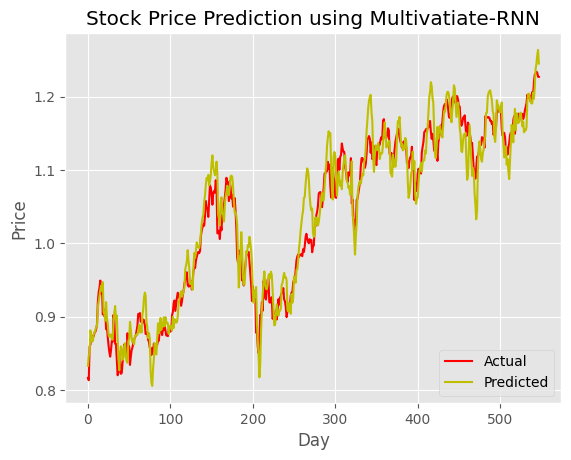

In [43]:
plot_data_2(true, predicted)

In [44]:
# Save a model
model.save('10VAR-VN30index-rnn.keras')

In [ ]:
del model

# Model 2: Multivariate-3-GRU

## GRU

### Import các thư viện cần thiết

In [45]:
import os
os.environ['PYTHONHASHSEED'] = '0' # đảm bảo rằng các giá trị băm của đối tượng bất biến (dict, set, chuỗi, tuple...) luôn giống nhau giữa các lần chạy

import random as rn
import numpy as np
np.random.seed(1)
rn.seed(3)
import tensorflow as tf
tf.random.set_seed(2)

In [46]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [47]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, GRU, Dropout
from tensorflow.keras import optimizers

In [48]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from math import sqrt
import datetime as dt
import time

from tensorflow.keras.optimizers import Adam

In [49]:
plt.style.use('ggplot')

### Hàm callback

In [50]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')  
checkpoint = ModelCheckpoint(
    filepath="10Var-Vn30-gru.h5",   # Tên file lưu mô hình
    monitor="val_loss",         # Theo dõi val_loss
    save_best_only=True,        # Chỉ lưu khi tốt hơn mô hình trước đó
    mode="min",                 # Giảm min của val_loss là tốt nhất
    verbose=1
)
callbacks_list = [earlystop, checkpoint] 

### Đọc dữ liệu từ file csv

In [ ]:
url = r"VN30 Index.csv"
df = pd.read_csv(url, parse_dates= True, index_col= 0)

In [42]:
df.head()

,open,high,low,close,volume
time,,,,,
2009-01-05,311.23,311.23,311.23,311.23,NaN
2009-01-06,314.21,314.21,314.21,314.21,NaN
2009-01-07,320.53,320.53,320.53,320.53,NaN
2009-01-08,314.14,314.14,314.14,314.14,NaN
2009-01-09,312.90,312.90,312.90,312.90,NaN


In [43]:
df.isnull().sum()

open        0
high        0
low         0
close       0
volume    859
dtype: int64

### Tiền xử lí dữ liệu

In [44]:
# Xóa các dòng có giá trị Volume bằng 0
df.drop(df[df['volume']==0].index, inplace=True)

In [45]:
# Ma trận tương quan (ở đây là Pearson tương quan tuyến tính)
df.corr()['close']

open      0.999562
high      0.999783
low       0.999789
close     1.000000
volume    0.169492
Name: close, dtype: float64

In [46]:
print(df.describe().volume) 

count    3.185000e+03
mean     3.279171e+06
std      2.776577e+07
min      4.540000e+03
25%      3.809000e+04
50%      6.036000e+04
75%      1.560100e+05
max      3.744900e+08
Name: volume, dtype: float64


<Axes: >

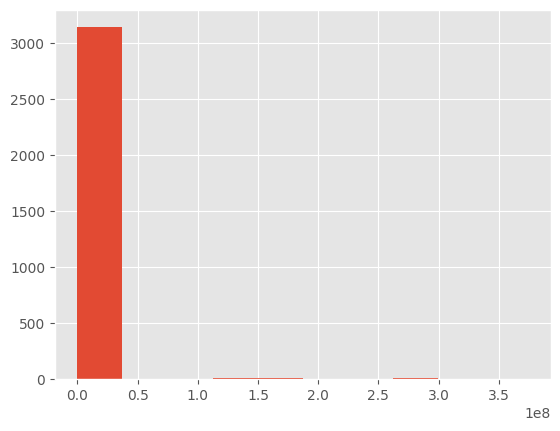

In [47]:
df['volume'].hist(bins= 10)

In [ ]:
# Bổ sung các chỉ báo kĩ thuật

# Tính CMA10
df['CMA10'] = df['close'].rolling(window=10, center=True).mean()
# Tính SMA10
df['SMA10'] = df['close'].rolling(window=10).mean()
# Tính SMA50
df['SMA50'] = df['close'].rolling(window=50).mean()
# Tính EMA12 và EMA26
df['EMA12'] = df['close'].ewm(span=12, adjust=False).mean()
df['EMA26'] = df['close'].ewm(span=26, adjust=False).mean()
# Tính MACD
df['MACD'] = df['EMA12'] - df['EMA26']
#Tính RSI
# Tính giá tăng/giảm
delta = df['close'].diff()

# Tính giá tăng
gain = delta.where(delta > 0, 0)

# Tính giá giảm
loss = -delta.where(delta < 0, 0)

# Tính trung bình động
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

# Tính RS và RSI
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

#Tính CCI
# Tính giá trung bình
typical_price = (df['high'] + df['low'] + df['close']) / 3

# Tính SMA của giá trung bình
sma_typical_price = typical_price.rolling(window=20).mean()

# Tính độ lệch chuẩn
mean_deviation = typical_price.rolling(window=20).apply(lambda x: np.mean(np.abs(x - x.mean())))

# Tính CCI
df['CCI'] = (typical_price - sma_typical_price) / (0.015 * mean_deviation)
# Tính %K và %D
low_min = df['low'].rolling(window=14).min()
high_max = df['high'].rolling(window=14).max()

df['%K'] = 100 * (df['close'] - low_min) / (high_max - low_min)
df['%D'] = df['%K'].rolling(window=3).mean()

In [51]:
print(df.head())
df.shape

              open    high     low   close  volume  CMA10  SMA10  SMA50  \
time                                                                      
2009-01-05  311.23  311.23  311.23  311.23     NaN    NaN    NaN    NaN   
2009-01-06  314.21  314.21  314.21  314.21     NaN    NaN    NaN    NaN   
2009-01-07  320.53  320.53  320.53  320.53     NaN    NaN    NaN    NaN   
2009-01-08  314.14  314.14  314.14  314.14     NaN    NaN    NaN    NaN   
2009-01-09  312.90  312.90  312.90  312.90     NaN    NaN    NaN    NaN   

                 EMA12       EMA26      MACD  RSI  CCI  %K  %D  
time                                                            
2009-01-05  311.230000  311.230000  0.000000  NaN  NaN NaN NaN  
2009-01-06  311.688462  311.450741  0.237721  NaN  NaN NaN NaN  
2009-01-07  313.048698  312.123278  0.925420  NaN  NaN NaN NaN  
2009-01-08  313.216591  312.272665  0.943926  NaN  NaN NaN NaN  
2009-01-09  313.167885  312.319134  0.848750  NaN  NaN NaN NaN  


(4044, 15)

## Train model / Hàm **fit_model_3()**

In [52]:
def fit_model_3(train, val, timesteps, hl, lr, batch, epochs):
    """
    np.random.seed(1)
    tf.random.set_seed(2)
    rn.seed(3)
    """
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []

    for i in range(timesteps, train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)

    for i in range(timesteps, val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val, Y_val = np.array(X_val), np.array(Y_val)

    # Thêm các lớp vào mô hình
    model = Sequential()
    model.add(GRU(X_train.shape[2], input_shape= (X_train.shape[1], X_train.shape[2]), activation= 'relu', return_sequences= True))
    for i in range(len(hl)-1):
        model.add(GRU(hl[i], activation='relu', return_sequences= True))
    model.add(GRU(hl[-1], activation='relu'))
    model.add(Dense(1))

    # Biên dịch
    model.compile(optimizer= optimizers.Adam(learning_rate= lr), loss= 'mean_squared_error')

    # Huấn luyện dữ liệu
    history = model.fit(X_train, Y_train, epochs= epochs, batch_size= batch, validation_data= (X_val, Y_val), verbose= 0, shuffle= False, callbacks= callbacks_list)
    
    # Đặt lại trạng thái
    for layer in model.layers:
        if isinstance(layer, GRU):
            layer.reset_states()
    
    return model, history.history['loss'], history.history['val_loss']

## Hàm **Evaluate_model_3()**

In [53]:
def evaluate_model_3(model, test, timesteps):
    """
    np.random.seed(1)
    tf.random.set_seed(2)
    """
    X_test = []
    Y_test = []

    for i in range(timesteps, test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test, Y_test= np.array(X_test), np.array(Y_test)

    # Các chỉ số đánh giá
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test, Y_hat)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(Y_test, Y_hat)
    r2 = r2_score(Y_test, Y_hat)

    return mse, rmse, mape, r2, Y_test, Y_hat


## **Grid Search**: Tìm kiếm siêu tham số tối ưu 

In [54]:
param_grid = {
    'timesteps': [30, 40, 50],
    'hl': [[40, 35]],
    'lr': [1e-4, 1e-3],
    'batch_size': [32, 64],
    'num_epochs': [200, 250]
}

In [55]:
# Hàm grid search
def grid_search_rnn(train, val, test, param_grid):
    results = []
    best_score = float('inf')
    best_params = None

    # Tạo tất cả các tổ hợp tham số
    all_combinations = list(product(*(param_grid.values())))
    param_names = param_grid.keys()

    for combination in all_combinations:
        # Gán giá trị tham số hiện tại
        params = dict(zip(param_names, combination))
        hl = params['hl']
        lr = params['lr']
        batch_size = params['batch_size']
        num_epochs = params['num_epochs']

        print(f'Training with params: {params}')

        # Huấn luyện mô hình
        model, train_loss, val_loss = fit_model_3(train, val, timesteps, hl, lr, batch_size, num_epochs)

        # Đánh giá mô hình
        mse, rmse, mape, r2, _, _ = evaluate_model_3(model, test, timesteps)

        # Lưu kết quả
        results.append({
            'timesteps': timesteps,
            'hl': hl,
            'lr': lr,
            'batch_size': batch_size,
            'num_epochs': num_epochs,
            'mse': mse,
            'rmse': rmse,
            'mape': mape,
            'r2': r2
        })

        # Cập nhật tham số tốt nhất nếu RMSE cải thiện
        if rmse < best_score:
            best_score = rmse
            best_params = params

        # Trả về kết quả
        results_df = pd.DataFrame(results)
        return best_params, best_score, results_df


## Plot chart (vẽ biểu đồ)

In [56]:
# Plotting the predictions
def plot_data_3(Y_test, Y_hat):
    plt.plot(Y_test, c = 'r')
    plt.plot(Y_hat, c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title("Stock Price Prediction using Multivariate-GRU")
    plt.legend(['Actual','Predicted'], loc = 'lower right')
    plt.show()

In [57]:
# Plotting the training errors: trực quan loss qua các epoch -> thấy qtr học mô hình, xem có overfitting ko
def plot_error(train_loss, val_loss):
    plt.plot(train_loss, c = 'r')
    plt.plot(val_loss, c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Train Loss and Validation Loss Curve')
    plt.legend(['train', 'val'], loc = 'upper right')
    plt.show()

## **Model building**: Xây dựng mô hình

### Bước 1: Trích xuất và trực quan hóa dữ liệu

In [58]:
# Extracting the series
series = df[['close', 'CMA10', 'SMA10', 'SMA50', 'EMA12', 'RSI', 'CCI', '%K', '%D', 'MACD']]
# Drop rows with NaN values
series = series.dropna()

# Display the shape and the tail of the cleaned series
print(series.shape)
print(series.tail())

(3991, 10)
              close     CMA10     SMA10      SMA50        EMA12        RSI  \
time                                                                         
2025-03-10  1391.07  1381.379  1369.467  1336.1956  1368.821086  81.914388   
2025-03-11  1393.57  1384.753  1372.768  1337.6066  1372.628611  80.831758   
2025-03-12  1392.39  1386.820  1375.951  1338.9890  1375.668825  78.354464   
2025-03-13  1387.30  1388.192  1378.319  1339.8854  1377.458236  71.932575   
2025-03-14  1387.03  1388.125  1381.379  1340.7724  1378.930815  67.050447   

                   CCI         %K         %D       MACD  
time                                                     
2025-03-10  186.248408  86.033606  94.302545  14.085059  
2025-03-11  143.873911  88.007313  90.655860  15.015993  
2025-03-12  152.955891  84.673892  86.238270  15.480105  
2025-03-13  121.672693  73.658150  82.113118  15.261273  
2025-03-14   97.327890  73.123391  77.151811  14.894368  


### Bước 2: Chia dữ liệu thành các tập Train, Validation, Test

In [59]:
series.shape

(3991, 10)

In [60]:
n = series.shape[0]
val_size =  test_size = int(n * 0.15)
train_size = n - val_size - test_size # Để tránh sai số làm mất dữ liệu

# Chia tập dữ liệu theo thứ tự thời gian
train_data = series.iloc[:train_size].values
val_data = series.iloc[train_size:train_size + val_size].values
test_data = series.iloc[(train_size + val_size):].values
# Kiểm tra kích thước của từng tập
print(train_data.shape, val_data.shape, test_data.shape)

(2795, 10) (598, 10) (598, 10)


### Bước 3: Chuẩn hóa dữ liệu bằng MinMaxScaler

In [61]:
# Normalisation
np.random.seed(1)
tf.random.set_seed(2)

sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)

print(train.shape, val.shape, test.shape)

(2795, 10) (598, 10) (598, 10)


### Bước 4: Tìm siêu tham số tốt nhất bằng Grid Search

In [62]:
best_params, best_score, results_df = grid_search_rnn(train, val, test, param_grid)

print(results_df)
print("Best parameters:", best_params)
print("Best RMSE score:", best_score)

Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss improved from inf to 1.03914, saving model to 10Var-Vn30-gru.h5



Epoch 2: val_loss improved from 1.03914 to 0.71168, saving model to 10Var-Vn30-gru.h5



Epoch 3: val_loss improved from 0.71168 to 0.36018, saving model to 10Var-Vn30-gru.h5



Epoch 4: val_loss improved from 0.36018 to 0.22008, saving model to 10Var-Vn30-gru.h5



Epoch 5: val_loss improved from 0.22008 to 0.18130, saving model to 10Var-Vn30-gru.h5



Epoch 6: val_loss improved from 0.18130 to 0.16611, saving model to 10Var-Vn30-gru.h5



Epoch 7: val_loss improved from 0.16611 to 0.14674, saving model to 10Var-Vn30-gru.h5



Epoch 8: val_loss improved from 0.14674 to 0.13171, saving model to 10Var-Vn30-gru.h5



Epoch 9: val_loss improved from 0.13171 to 0.11219, saving model to 10Var-Vn30-gru.h5



Epoch 10: val_loss improved from 0.11219 to 0.09802, saving model to 10Var-Vn30-gru.h5



Epoch 11: val_loss improved from 0.09802 to 0.08010, saving model to 10Var-Vn30-gru.h5



Epoch 12: val_loss improved from 0.08010 to 0.05970, saving model to 10Var-Vn30-gru.h5



Epoch 13: val_loss improved from 0.05970 to 0.04471, saving model to 10Var-Vn30-gru.h5



Epoch 14: val_loss improved from 0.04471 to 0.03505, saving model to 10Var-Vn30-gru.h5



Epoch 15: val_loss improved from 0.03505 to 0.02858, saving model to 10Var-Vn30-gru.h5



Epoch 16: val_loss improved from 0.02858 to 0.02410, saving model to 10Var-Vn30-gru.h5



Epoch 17: val_loss improved from 0.02410 to 0.02100, saving model to 10Var-Vn30-gru.h5



Epoch 18: val_loss improved from 0.02100 to 0.01910, saving model to 10Var-Vn30-gru.h5



Epoch 19: val_loss improved from 0.01910 to 0.01770, saving model to 10Var-Vn30-gru.h5



Epoch 20: val_loss improved from 0.01770 to 0.01674, saving model to 10Var-Vn30-gru.h5



Epoch 21: val_loss improved from 0.01674 to 0.01602, saving model to 10Var-Vn30-gru.h5



Epoch 22: val_loss improved from 0.01602 to 0.01545, saving model to 10Var-Vn30-gru.h5



Epoch 23: val_loss improved from 0.01545 to 0.01504, saving model to 10Var-Vn30-gru.h5



Epoch 24: val_loss improved from 0.01504 to 0.01466, saving model to 10Var-Vn30-gru.h5



Epoch 25: val_loss improved from 0.01466 to 0.01433, saving model to 10Var-Vn30-gru.h5



Epoch 26: val_loss improved from 0.01433 to 0.01404, saving model to 10Var-Vn30-gru.h5



Epoch 27: val_loss improved from 0.01404 to 0.01379, saving model to 10Var-Vn30-gru.h5



Epoch 28: val_loss improved from 0.01379 to 0.01356, saving model to 10Var-Vn30-gru.h5



Epoch 29: val_loss improved from 0.01356 to 0.01332, saving model to 10Var-Vn30-gru.h5



Epoch 30: val_loss improved from 0.01332 to 0.01314, saving model to 10Var-Vn30-gru.h5



Epoch 31: val_loss improved from 0.01314 to 0.01301, saving model to 10Var-Vn30-gru.h5



Epoch 32: val_loss improved from 0.01301 to 0.01274, saving model to 10Var-Vn30-gru.h5



Epoch 33: val_loss improved from 0.01274 to 0.01249, saving model to 10Var-Vn30-gru.h5



Epoch 34: val_loss improved from 0.01249 to 0.01224, saving model to 10Var-Vn30-gru.h5



Epoch 35: val_loss improved from 0.01224 to 0.01201, saving model to 10Var-Vn30-gru.h5



Epoch 36: val_loss improved from 0.01201 to 0.01176, saving model to 10Var-Vn30-gru.h5



Epoch 37: val_loss improved from 0.01176 to 0.01158, saving model to 10Var-Vn30-gru.h5



Epoch 38: val_loss improved from 0.01158 to 0.01144, saving model to 10Var-Vn30-gru.h5



Epoch 39: val_loss improved from 0.01144 to 0.01128, saving model to 10Var-Vn30-gru.h5



Epoch 40: val_loss improved from 0.01128 to 0.01116, saving model to 10Var-Vn30-gru.h5



Epoch 41: val_loss improved from 0.01116 to 0.01104, saving model to 10Var-Vn30-gru.h5



Epoch 42: val_loss improved from 0.01104 to 0.01091, saving model to 10Var-Vn30-gru.h5



Epoch 43: val_loss improved from 0.01091 to 0.01081, saving model to 10Var-Vn30-gru.h5



Epoch 44: val_loss improved from 0.01081 to 0.01069, saving model to 10Var-Vn30-gru.h5



Epoch 45: val_loss improved from 0.01069 to 0.01063, saving model to 10Var-Vn30-gru.h5



Epoch 46: val_loss improved from 0.01063 to 0.01052, saving model to 10Var-Vn30-gru.h5



Epoch 47: val_loss improved from 0.01052 to 0.01046, saving model to 10Var-Vn30-gru.h5



Epoch 48: val_loss improved from 0.01046 to 0.01036, saving model to 10Var-Vn30-gru.h5



Epoch 49: val_loss improved from 0.01036 to 0.01031, saving model to 10Var-Vn30-gru.h5



Epoch 50: val_loss improved from 0.01031 to 0.01021, saving model to 10Var-Vn30-gru.h5



Epoch 51: val_loss improved from 0.01021 to 0.01015, saving model to 10Var-Vn30-gru.h5



Epoch 52: val_loss improved from 0.01015 to 0.01006, saving model to 10Var-Vn30-gru.h5



Epoch 53: val_loss improved from 0.01006 to 0.01000, saving model to 10Var-Vn30-gru.h5



Epoch 54: val_loss did not improve from 0.01000

Epoch 55: val_loss improved from 0.01000 to 0.00980, saving model to 10Var-Vn30-gru.h5



Epoch 56: val_loss improved from 0.00980 to 0.00973, saving model to 10Var-Vn30-gru.h5



Epoch 57: val_loss improved from 0.00973 to 0.00965, saving model to 10Var-Vn30-gru.h5



Epoch 58: val_loss improved from 0.00965 to 0.00957, saving model to 10Var-Vn30-gru.h5



Epoch 59: val_loss improved from 0.00957 to 0.00948, saving model to 10Var-Vn30-gru.h5



Epoch 60: val_loss improved from 0.00948 to 0.00942, saving model to 10Var-Vn30-gru.h5



Epoch 61: val_loss improved from 0.00942 to 0.00933, saving model to 10Var-Vn30-gru.h5



Epoch 62: val_loss improved from 0.00933 to 0.00927, saving model to 10Var-Vn30-gru.h5



Epoch 63: val_loss improved from 0.00927 to 0.00918, saving model to 10Var-Vn30-gru.h5



Epoch 64: val_loss improved from 0.00918 to 0.00913, saving model to 10Var-Vn30-gru.h5



Epoch 65: val_loss improved from 0.00913 to 0.00905, saving model to 10Var-Vn30-gru.h5



Epoch 66: val_loss improved from 0.00905 to 0.00898, saving model to 10Var-Vn30-gru.h5



Epoch 67: val_loss improved from 0.00898 to 0.00890, saving model to 10Var-Vn30-gru.h5



Epoch 68: val_loss improved from 0.00890 to 0.00883, saving model to 10Var-Vn30-gru.h5



Epoch 69: val_loss improved from 0.00883 to 0.00875, saving model to 10Var-Vn30-gru.h5



Epoch 70: val_loss improved from 0.00875 to 0.00867, saving model to 10Var-Vn30-gru.h5



Epoch 71: val_loss improved from 0.00867 to 0.00859, saving model to 10Var-Vn30-gru.h5



Epoch 72: val_loss improved from 0.00859 to 0.00851, saving model to 10Var-Vn30-gru.h5



Epoch 73: val_loss improved from 0.00851 to 0.00843, saving model to 10Var-Vn30-gru.h5



Epoch 74: val_loss improved from 0.00843 to 0.00834, saving model to 10Var-Vn30-gru.h5



Epoch 75: val_loss improved from 0.00834 to 0.00826, saving model to 10Var-Vn30-gru.h5



Epoch 76: val_loss improved from 0.00826 to 0.00819, saving model to 10Var-Vn30-gru.h5



Epoch 77: val_loss improved from 0.00819 to 0.00813, saving model to 10Var-Vn30-gru.h5



Epoch 78: val_loss improved from 0.00813 to 0.00808, saving model to 10Var-Vn30-gru.h5



Epoch 79: val_loss improved from 0.00808 to 0.00798, saving model to 10Var-Vn30-gru.h5



Epoch 80: val_loss improved from 0.00798 to 0.00791, saving model to 10Var-Vn30-gru.h5



Epoch 81: val_loss improved from 0.00791 to 0.00783, saving model to 10Var-Vn30-gru.h5



Epoch 82: val_loss improved from 0.00783 to 0.00774, saving model to 10Var-Vn30-gru.h5



Epoch 83: val_loss improved from 0.00774 to 0.00766, saving model to 10Var-Vn30-gru.h5



Epoch 84: val_loss improved from 0.00766 to 0.00756, saving model to 10Var-Vn30-gru.h5



Epoch 85: val_loss improved from 0.00756 to 0.00747, saving model to 10Var-Vn30-gru.h5



Epoch 86: val_loss improved from 0.00747 to 0.00738, saving model to 10Var-Vn30-gru.h5



Epoch 87: val_loss improved from 0.00738 to 0.00729, saving model to 10Var-Vn30-gru.h5



Epoch 88: val_loss improved from 0.00729 to 0.00720, saving model to 10Var-Vn30-gru.h5



Epoch 89: val_loss improved from 0.00720 to 0.00710, saving model to 10Var-Vn30-gru.h5



Epoch 90: val_loss improved from 0.00710 to 0.00701, saving model to 10Var-Vn30-gru.h5



Epoch 91: val_loss improved from 0.00701 to 0.00692, saving model to 10Var-Vn30-gru.h5



Epoch 92: val_loss improved from 0.00692 to 0.00682, saving model to 10Var-Vn30-gru.h5



Epoch 93: val_loss improved from 0.00682 to 0.00672, saving model to 10Var-Vn30-gru.h5



Epoch 94: val_loss improved from 0.00672 to 0.00664, saving model to 10Var-Vn30-gru.h5



Epoch 95: val_loss improved from 0.00664 to 0.00654, saving model to 10Var-Vn30-gru.h5



Epoch 96: val_loss improved from 0.00654 to 0.00646, saving model to 10Var-Vn30-gru.h5



Epoch 97: val_loss improved from 0.00646 to 0.00636, saving model to 10Var-Vn30-gru.h5



Epoch 98: val_loss improved from 0.00636 to 0.00628, saving model to 10Var-Vn30-gru.h5



Epoch 99: val_loss improved from 0.00628 to 0.00619, saving model to 10Var-Vn30-gru.h5



Epoch 100: val_loss improved from 0.00619 to 0.00610, saving model to 10Var-Vn30-gru.h5



Epoch 101: val_loss improved from 0.00610 to 0.00601, saving model to 10Var-Vn30-gru.h5



Epoch 102: val_loss improved from 0.00601 to 0.00592, saving model to 10Var-Vn30-gru.h5



Epoch 103: val_loss improved from 0.00592 to 0.00583, saving model to 10Var-Vn30-gru.h5



Epoch 104: val_loss improved from 0.00583 to 0.00575, saving model to 10Var-Vn30-gru.h5



Epoch 105: val_loss improved from 0.00575 to 0.00566, saving model to 10Var-Vn30-gru.h5



Epoch 106: val_loss improved from 0.00566 to 0.00558, saving model to 10Var-Vn30-gru.h5



Epoch 107: val_loss improved from 0.00558 to 0.00549, saving model to 10Var-Vn30-gru.h5



Epoch 108: val_loss improved from 0.00549 to 0.00541, saving model to 10Var-Vn30-gru.h5



Epoch 109: val_loss improved from 0.00541 to 0.00532, saving model to 10Var-Vn30-gru.h5



Epoch 110: val_loss improved from 0.00532 to 0.00523, saving model to 10Var-Vn30-gru.h5



Epoch 111: val_loss improved from 0.00523 to 0.00514, saving model to 10Var-Vn30-gru.h5



Epoch 112: val_loss improved from 0.00514 to 0.00505, saving model to 10Var-Vn30-gru.h5



Epoch 113: val_loss improved from 0.00505 to 0.00496, saving model to 10Var-Vn30-gru.h5



Epoch 114: val_loss improved from 0.00496 to 0.00486, saving model to 10Var-Vn30-gru.h5



Epoch 115: val_loss improved from 0.00486 to 0.00478, saving model to 10Var-Vn30-gru.h5



Epoch 116: val_loss improved from 0.00478 to 0.00469, saving model to 10Var-Vn30-gru.h5



Epoch 117: val_loss improved from 0.00469 to 0.00461, saving model to 10Var-Vn30-gru.h5



Epoch 118: val_loss improved from 0.00461 to 0.00452, saving model to 10Var-Vn30-gru.h5



Epoch 119: val_loss improved from 0.00452 to 0.00445, saving model to 10Var-Vn30-gru.h5



Epoch 120: val_loss improved from 0.00445 to 0.00436, saving model to 10Var-Vn30-gru.h5



Epoch 121: val_loss improved from 0.00436 to 0.00429, saving model to 10Var-Vn30-gru.h5



Epoch 122: val_loss improved from 0.00429 to 0.00422, saving model to 10Var-Vn30-gru.h5



Epoch 123: val_loss improved from 0.00422 to 0.00415, saving model to 10Var-Vn30-gru.h5



Epoch 124: val_loss improved from 0.00415 to 0.00408, saving model to 10Var-Vn30-gru.h5



Epoch 125: val_loss improved from 0.00408 to 0.00401, saving model to 10Var-Vn30-gru.h5



Epoch 126: val_loss improved from 0.00401 to 0.00394, saving model to 10Var-Vn30-gru.h5



Epoch 127: val_loss improved from 0.00394 to 0.00388, saving model to 10Var-Vn30-gru.h5



Epoch 128: val_loss improved from 0.00388 to 0.00382, saving model to 10Var-Vn30-gru.h5



Epoch 129: val_loss improved from 0.00382 to 0.00375, saving model to 10Var-Vn30-gru.h5



Epoch 130: val_loss improved from 0.00375 to 0.00369, saving model to 10Var-Vn30-gru.h5



Epoch 131: val_loss improved from 0.00369 to 0.00363, saving model to 10Var-Vn30-gru.h5



Epoch 132: val_loss improved from 0.00363 to 0.00357, saving model to 10Var-Vn30-gru.h5



Epoch 133: val_loss improved from 0.00357 to 0.00351, saving model to 10Var-Vn30-gru.h5



Epoch 134: val_loss improved from 0.00351 to 0.00345, saving model to 10Var-Vn30-gru.h5



Epoch 135: val_loss improved from 0.00345 to 0.00339, saving model to 10Var-Vn30-gru.h5



Epoch 136: val_loss improved from 0.00339 to 0.00333, saving model to 10Var-Vn30-gru.h5



Epoch 137: val_loss improved from 0.00333 to 0.00327, saving model to 10Var-Vn30-gru.h5



Epoch 138: val_loss improved from 0.00327 to 0.00321, saving model to 10Var-Vn30-gru.h5



Epoch 139: val_loss improved from 0.00321 to 0.00315, saving model to 10Var-Vn30-gru.h5



Epoch 140: val_loss improved from 0.00315 to 0.00309, saving model to 10Var-Vn30-gru.h5



Epoch 141: val_loss improved from 0.00309 to 0.00302, saving model to 10Var-Vn30-gru.h5



Epoch 142: val_loss improved from 0.00302 to 0.00296, saving model to 10Var-Vn30-gru.h5



Epoch 143: val_loss improved from 0.00296 to 0.00290, saving model to 10Var-Vn30-gru.h5



Epoch 144: val_loss improved from 0.00290 to 0.00284, saving model to 10Var-Vn30-gru.h5



Epoch 145: val_loss improved from 0.00284 to 0.00278, saving model to 10Var-Vn30-gru.h5



Epoch 146: val_loss improved from 0.00278 to 0.00273, saving model to 10Var-Vn30-gru.h5



Epoch 147: val_loss improved from 0.00273 to 0.00267, saving model to 10Var-Vn30-gru.h5



Epoch 148: val_loss improved from 0.00267 to 0.00261, saving model to 10Var-Vn30-gru.h5



Epoch 149: val_loss improved from 0.00261 to 0.00255, saving model to 10Var-Vn30-gru.h5



Epoch 150: val_loss improved from 0.00255 to 0.00250, saving model to 10Var-Vn30-gru.h5



Epoch 151: val_loss improved from 0.00250 to 0.00245, saving model to 10Var-Vn30-gru.h5



Epoch 152: val_loss improved from 0.00245 to 0.00240, saving model to 10Var-Vn30-gru.h5



Epoch 153: val_loss improved from 0.00240 to 0.00236, saving model to 10Var-Vn30-gru.h5



Epoch 154: val_loss improved from 0.00236 to 0.00231, saving model to 10Var-Vn30-gru.h5



Epoch 155: val_loss improved from 0.00231 to 0.00227, saving model to 10Var-Vn30-gru.h5



Epoch 156: val_loss improved from 0.00227 to 0.00223, saving model to 10Var-Vn30-gru.h5



Epoch 157: val_loss improved from 0.00223 to 0.00219, saving model to 10Var-Vn30-gru.h5



Epoch 158: val_loss improved from 0.00219 to 0.00215, saving model to 10Var-Vn30-gru.h5



Epoch 159: val_loss improved from 0.00215 to 0.00211, saving model to 10Var-Vn30-gru.h5



Epoch 160: val_loss improved from 0.00211 to 0.00208, saving model to 10Var-Vn30-gru.h5



Epoch 161: val_loss improved from 0.00208 to 0.00204, saving model to 10Var-Vn30-gru.h5



Epoch 162: val_loss improved from 0.00204 to 0.00200, saving model to 10Var-Vn30-gru.h5



Epoch 163: val_loss improved from 0.00200 to 0.00197, saving model to 10Var-Vn30-gru.h5



Epoch 164: val_loss improved from 0.00197 to 0.00193, saving model to 10Var-Vn30-gru.h5



Epoch 165: val_loss improved from 0.00193 to 0.00190, saving model to 10Var-Vn30-gru.h5



Epoch 166: val_loss improved from 0.00190 to 0.00187, saving model to 10Var-Vn30-gru.h5



Epoch 167: val_loss improved from 0.00187 to 0.00183, saving model to 10Var-Vn30-gru.h5



Epoch 168: val_loss improved from 0.00183 to 0.00180, saving model to 10Var-Vn30-gru.h5



Epoch 169: val_loss improved from 0.00180 to 0.00177, saving model to 10Var-Vn30-gru.h5



Epoch 170: val_loss improved from 0.00177 to 0.00174, saving model to 10Var-Vn30-gru.h5



Epoch 171: val_loss improved from 0.00174 to 0.00170, saving model to 10Var-Vn30-gru.h5



Epoch 172: val_loss improved from 0.00170 to 0.00166, saving model to 10Var-Vn30-gru.h5



Epoch 173: val_loss improved from 0.00166 to 0.00163, saving model to 10Var-Vn30-gru.h5



Epoch 174: val_loss improved from 0.00163 to 0.00160, saving model to 10Var-Vn30-gru.h5



Epoch 175: val_loss improved from 0.00160 to 0.00156, saving model to 10Var-Vn30-gru.h5



Epoch 176: val_loss improved from 0.00156 to 0.00153, saving model to 10Var-Vn30-gru.h5



Epoch 177: val_loss improved from 0.00153 to 0.00150, saving model to 10Var-Vn30-gru.h5



Epoch 178: val_loss improved from 0.00150 to 0.00146, saving model to 10Var-Vn30-gru.h5



Epoch 179: val_loss improved from 0.00146 to 0.00142, saving model to 10Var-Vn30-gru.h5



Epoch 180: val_loss improved from 0.00142 to 0.00139, saving model to 10Var-Vn30-gru.h5



Epoch 181: val_loss improved from 0.00139 to 0.00136, saving model to 10Var-Vn30-gru.h5



Epoch 182: val_loss improved from 0.00136 to 0.00133, saving model to 10Var-Vn30-gru.h5



Epoch 183: val_loss improved from 0.00133 to 0.00130, saving model to 10Var-Vn30-gru.h5



Epoch 184: val_loss improved from 0.00130 to 0.00127, saving model to 10Var-Vn30-gru.h5



Epoch 185: val_loss improved from 0.00127 to 0.00124, saving model to 10Var-Vn30-gru.h5



Epoch 186: val_loss improved from 0.00124 to 0.00121, saving model to 10Var-Vn30-gru.h5



Epoch 187: val_loss improved from 0.00121 to 0.00119, saving model to 10Var-Vn30-gru.h5



Epoch 188: val_loss improved from 0.00119 to 0.00116, saving model to 10Var-Vn30-gru.h5



Epoch 189: val_loss improved from 0.00116 to 0.00114, saving model to 10Var-Vn30-gru.h5



Epoch 190: val_loss improved from 0.00114 to 0.00112, saving model to 10Var-Vn30-gru.h5



Epoch 191: val_loss improved from 0.00112 to 0.00110, saving model to 10Var-Vn30-gru.h5



Epoch 192: val_loss improved from 0.00110 to 0.00109, saving model to 10Var-Vn30-gru.h5



Epoch 193: val_loss improved from 0.00109 to 0.00107, saving model to 10Var-Vn30-gru.h5



Epoch 194: val_loss improved from 0.00107 to 0.00106, saving model to 10Var-Vn30-gru.h5



Epoch 195: val_loss improved from 0.00106 to 0.00104, saving model to 10Var-Vn30-gru.h5



Epoch 196: val_loss improved from 0.00104 to 0.00103, saving model to 10Var-Vn30-gru.h5



Epoch 197: val_loss improved from 0.00103 to 0.00102, saving model to 10Var-Vn30-gru.h5



Epoch 198: val_loss improved from 0.00102 to 0.00100, saving model to 10Var-Vn30-gru.h5



Epoch 199: val_loss improved from 0.00100 to 0.00100, saving model to 10Var-Vn30-gru.h5



Epoch 200: val_loss improved from 0.00100 to 0.00099, saving model to 10Var-Vn30-gru.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step
   timesteps        hl      lr  batch_size  num_epochs       mse      rmse  \
0         50  [40, 35]  0.0001          32         200  0.000742  0.027243   

       mape        r2  
0  0.020988  0.944013  
Best parameters: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}
Best RMSE score: 0.02724254719812192


### Bước 5: Huấn luyện mô hình với bộ tham số tối ưu

In [63]:
timesteps = 30
hl = [40, 35]
lr = 1e-4
batch_size = 32
num_epochs = 200

model, train_loss, val_loss = fit_model_3(train, val, timesteps, hl, lr, batch_size, num_epochs)

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00099

Epoch 2: val_loss did not improve from 0.00099

Epoch 3: val_loss did not improve from 0.00099

Epoch 4: val_loss did not improve from 0.00099

Epoch 5: val_loss did not improve from 0.00099

Epoch 6: val_loss did not improve from 0.00099

Epoch 7: val_loss did not improve from 0.00099

Epoch 8: val_loss did not improve from 0.00099

Epoch 9: val_loss did not improve from 0.00099

Epoch 10: val_loss did not improve from 0.00099

Epoch 11: val_loss did not improve from 0.00099

Epoch 12: val_loss did not improve from 0.00099

Epoch 13: val_loss did not improve from 0.00099

Epoch 14: val_loss did not improve from 0.00099

Epoch 15: val_loss did not improve from 0.00099

Epoch 16: val_loss did not improve from 0.00099

Epoch 17: val_loss did not improve from 0.00099

Epoch 18: val_loss did not improve from 0.00099

Epoch 19: val_loss did not improve from 0.00099

Epoch 20: val_loss did not improve from 0.00099

Epoch 21: val_loss did not i


Epoch 60: val_loss improved from 0.00098 to 0.00097, saving model to 10Var-Vn30-gru.h5



Epoch 61: val_loss improved from 0.00097 to 0.00096, saving model to 10Var-Vn30-gru.h5



Epoch 62: val_loss improved from 0.00096 to 0.00095, saving model to 10Var-Vn30-gru.h5



Epoch 63: val_loss improved from 0.00095 to 0.00094, saving model to 10Var-Vn30-gru.h5



Epoch 64: val_loss improved from 0.00094 to 0.00094, saving model to 10Var-Vn30-gru.h5



Epoch 65: val_loss improved from 0.00094 to 0.00094, saving model to 10Var-Vn30-gru.h5



Epoch 66: val_loss improved from 0.00094 to 0.00094, saving model to 10Var-Vn30-gru.h5



Epoch 67: val_loss did not improve from 0.00094

Epoch 68: val_loss did not improve from 0.00094

Epoch 69: val_loss did not improve from 0.00094

Epoch 70: val_loss did not improve from 0.00094

Epoch 71: val_loss did not improve from 0.00094

Epoch 72: val_loss did not improve from 0.00094

Epoch 73: val_loss did not improve from 0.00094

Epoch 74: val_loss did not improve from 0.00094

Epoch 75: val_loss did not improve from 0.00094

Epoch 76: val_loss did not improve from 0.00094

Epoch 77: val_loss did not improve from 0.00094

Epoch 78: val_loss did not improve from 0.00094

Epoch 79: val_loss did not improve from 0.00094

Epoch 80: val_loss did not improve from 0.00094

Epoch 81: val_loss did not improve from 0.00094

Epoch 82: val_loss did not improve from 0.00094

Epoch 83: val_loss did not improve from 0.00094

Epoch 84: val_loss did not improve from 0.00094

Epoch 85: val_loss did not improve from 0.00094

Epoch 86: val_loss did not improve from 0.00094

Epoch 87: val_loss 

### Bước 6: Đánh giá mô hình và trực quan hóa kết quả

#### 6.1. Vẽ biểu đồ train_loss và val_loss

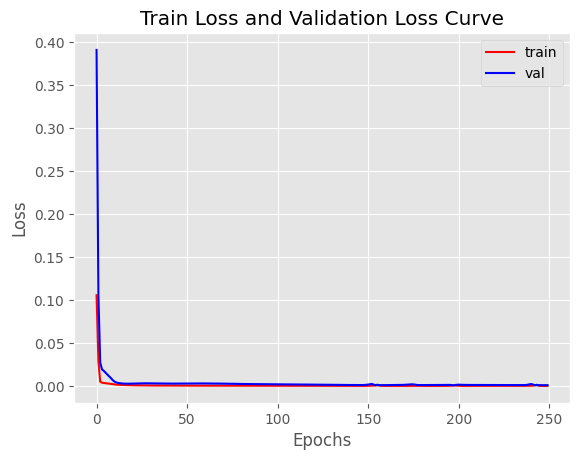

In [64]:
plot_error(train_error, val_error)

#### 6.2. Đánh giá mô hình trên tập test

In [65]:
mse, rmse, mape, r2, true, predicted = evaluate_model_3(model, test, timesteps)

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step


In [66]:
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('MAPE = {}'.format(mape))
print('R-Squared Score = {}'.format(r2))

MSE = 0.0007688355691376265
RMSE = 0.027727884324946727
MAPE = 0.02152507816561476
R-Squared Score = 0.9445823227225246


#### 6.3. Vẽ đồ thị dự đoán vs thực tế

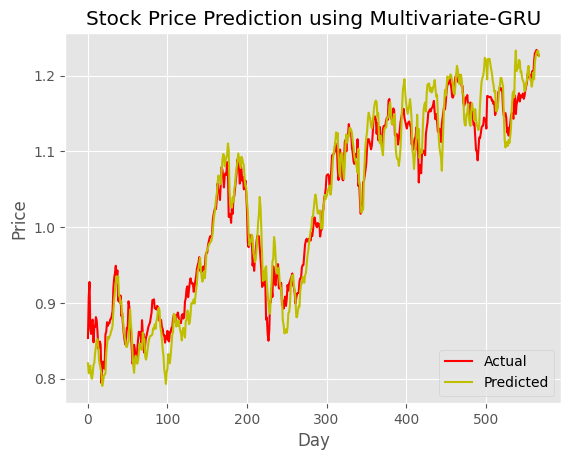

In [67]:
plot_data_3(true, predicted)

In [68]:
# Save a model
model.save('10VAR-VN30index-gru.keras')

In [206]:
del model

# Model 3: Multivariate-3-LSTM

## LSTM

### Import các thư viện cần thiết

In [2]:
import os
os.environ['PYTHONHASHSEED'] = '0' # đảm bảo rằng các giá trị băm của đối tượng bất biến (dict, set, chuỗi, tuple...) luôn giống nhau giữa các lần chạy

import random as rn
import numpy as np
np.random.seed(1)
rn.seed(3)
import tensorflow as tf
tf.random.set_seed(2)

In [3]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras import optimizers

In [5]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from math import sqrt
import datetime as dt
import time

In [6]:
plt.style.use('ggplot')

### Hàm callback

In [7]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')  
checkpoint = ModelCheckpoint(
    filepath="10Var_vn30_lstm.h5",   # Tên file lưu mô hình
    monitor="val_loss",         # Theo dõi val_loss
    save_best_only=True,        # Chỉ lưu khi tốt hơn mô hình trước đó
    mode="min",                 # Giảm min của val_loss là tốt nhất
    verbose=1
)
callbacks_list = [earlystop, checkpoint] 

### Đọc dữ liệu từ file csv

In [ ]:
url = r"VN30 Index.csv"
df = pd.read_csv(url, parse_dates= True, index_col= 0)

In [9]:
df.head()

,open,high,low,close,volume
time,,,,,
2009-01-05,311.23,311.23,311.23,311.23,NaN
2009-01-06,314.21,314.21,314.21,314.21,NaN
2009-01-07,320.53,320.53,320.53,320.53,NaN
2009-01-08,314.14,314.14,314.14,314.14,NaN
2009-01-09,312.90,312.90,312.90,312.90,NaN


In [10]:
df.isnull().sum()

open        0
high        0
low         0
close       0
volume    859
dtype: int64

### Tiền xử lí dữ liệu

In [11]:
# Xóa các dòng có giá trị Volume bằng 0
df.drop(df[df['volume']==0].index, inplace=True)

In [12]:
# Ma trận tương quan (ở đây là Pearson tương quan tuyến tính)
df.corr()['close']

open      0.999562
high      0.999783
low       0.999789
close     1.000000
volume    0.169492
Name: close, dtype: float64

count    3.185000e+03
mean     3.279171e+06
std      2.776577e+07
min      4.540000e+03
25%      3.809000e+04
50%      6.036000e+04
75%      1.560100e+05
max      3.744900e+08
Name: volume, dtype: float64


<Axes: >

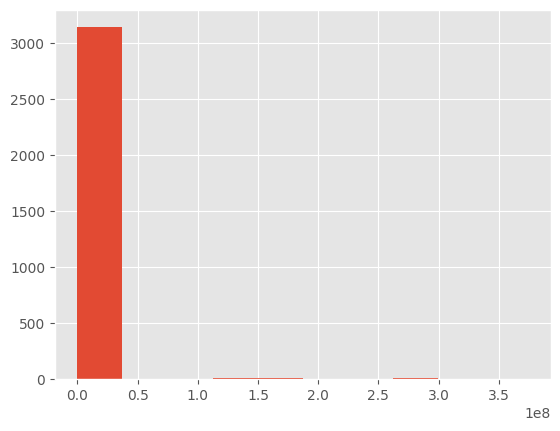

In [13]:
print(df.describe().volume) 
df['volume'].hist(bins= 10)

In [14]:
# Bổ sung các chỉ báo kĩ thuật

# Tính CMA10
df['CMA10'] = df['close'].rolling(window=10, center=True).mean()
# Tính SMA10
df['SMA10'] = df['close'].rolling(window=10).mean()
# Tính SMA50
df['SMA50'] = df['close'].rolling(window=50).mean()
# Tính EMA12 và EMA26
df['EMA12'] = df['close'].ewm(span=12, adjust=False).mean()
df['EMA26'] = df['close'].ewm(span=26, adjust=False).mean()
# Tính MACD
df['MACD'] = df['EMA12'] - df['EMA26']
#Tính RSI
# Tính giá tăng/giảm
delta = df['close'].diff()

# Tính giá tăng
gain = delta.where(delta > 0, 0)

# Tính giá giảm
loss = -delta.where(delta < 0, 0)

# Tính trung bình động
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

# Tính RS và RSI
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

#Tính CCI
# Tính giá trung bình
typical_price = (df['high'] + df['low'] + df['close']) / 3

# Tính SMA của giá trung bình
sma_typical_price = typical_price.rolling(window=20).mean()

# Tính độ lệch chuẩn
mean_deviation = typical_price.rolling(window=20).apply(lambda x: np.mean(np.abs(x - x.mean())))

# Tính CCI
df['CCI'] = (typical_price - sma_typical_price) / (0.015 * mean_deviation)
# Tính %K và %D
low_min = df['low'].rolling(window=14).min()
high_max = df['high'].rolling(window=14).max()

df['%K'] = 100 * (df['close'] - low_min) / (high_max - low_min)
df['%D'] = df['%K'].rolling(window=3).mean()

In [15]:
print(df.head())
df.shape

              open    high     low   close  volume  CMA10  SMA10  SMA50  \
time                                                                      
2009-01-05  311.23  311.23  311.23  311.23     NaN    NaN    NaN    NaN   
2009-01-06  314.21  314.21  314.21  314.21     NaN    NaN    NaN    NaN   
2009-01-07  320.53  320.53  320.53  320.53     NaN    NaN    NaN    NaN   
2009-01-08  314.14  314.14  314.14  314.14     NaN    NaN    NaN    NaN   
2009-01-09  312.90  312.90  312.90  312.90     NaN    NaN    NaN    NaN   

                 EMA12       EMA26      MACD  RSI  CCI  %K  %D  
time                                                            
2009-01-05  311.230000  311.230000  0.000000  NaN  NaN NaN NaN  
2009-01-06  311.688462  311.450741  0.237721  NaN  NaN NaN NaN  
2009-01-07  313.048698  312.123278  0.925420  NaN  NaN NaN NaN  
2009-01-08  313.216591  312.272665  0.943926  NaN  NaN NaN NaN  
2009-01-09  313.167885  312.319134  0.848750  NaN  NaN NaN NaN  


(4044, 15)

## Train model / Hàm **fit_model_4()**

In [16]:
def fit_model_4(train, val, timesteps, hl, lr, batch, epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []

    for i in range(timesteps, train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)

    for i in range(timesteps, val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val, Y_val = np.array(X_val), np.array(Y_val)

    # Xây dựng mô hình
    model = Sequential()
    model.add(LSTM(X_train.shape[2], input_shape= (X_train.shape[1], X_train.shape[2]), activation='relu', return_sequences= True))
    for i in range(len(hl)-1):
        model.add(LSTM(hl[i], activation='relu', return_sequences= True))
    model.add(LSTM(hl[-1], activation='relu'))
    model.add(Dense(1))

    # Biên dịch
    model.compile(optimizer= optimizers.Adam(learning_rate= lr), loss= 'mean_squared_error')

    # Huấn luyện mô hình
    history = model.fit(X_train, Y_train, batch_size= batch, epochs= epochs, validation_data= (X_val, Y_val), verbose= 0, shuffle= False, callbacks= callbacks_list)

    # Đặt lại trạng thái
    for layer in model.layers:
        if isinstance(layer, LSTM):
            layer.reset_state()

    return model, history.history['loss'], history.history['val_loss']

## Hàm **Evaluate_model_4()**

In [17]:
def evaluate_model_4(model, test, timesteps):
    X_test = []
    Y_test = []

    for i in range(timesteps, test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test, Y_test = np.array(X_test), np.array(Y_test)

    # Các chỉ số
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test, Y_hat)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(Y_test, Y_hat)
    r2 = r2_score(Y_test, Y_hat)

    return mse, rmse, mape, r2, Y_test, Y_hat

## **Grid Search**: Tìm kiếm siêu tham số tối ưu 

In [18]:
param_grid = {
    'timesteps': [30, 40, 50],  # Số giá trị trước đó để dự đoán
    'hl': [ [40, 35]], # Cấu trúc lớp ẩn
    'lr': [1e-3, 1e-4],  # Tốc độ học
    'batch_size': [32, 64],  # Kích thước batch
    'num_epochs': [200, 250],  # Số epoch
}

In [19]:
from itertools import product
import pandas as pd

# Hàm Grid Search
def grid_search_rnn(train, val, test, param_grid):
    results = []  # Lưu kết quả của từng tổ hợp tham số
    best_score = float('inf')  # Lưu RMSE tốt nhất
    best_params = None  # Lưu bộ tham số tốt nhất

    # Tạo tất cả các tổ hợp tham số
    all_combinations = list(product(*param_grid.values()))
    param_names = list(param_grid.keys())

    for combination in all_combinations:
        # Gán giá trị tham số hiện tại
        params = dict(zip(param_names, combination))
        timesteps = params['timesteps']
        hl = params['hl']
        lr = params['lr']
        batch_size = params['batch_size']
        num_epochs = params['num_epochs']

        print(f"Training with params: {params}")

        # Huấn luyện mô hình
        model, train_loss, val_loss = fit_model_4(
            train, val, timesteps, hl, lr, batch_size, num_epochs
        )

        # Đánh giá mô hình
        mse, rmse, mape, r2, _, _ = evaluate_model_4(model, test, timesteps)

        # Lưu kết quả
        results.append({
            'timesteps': timesteps,
            'hl': hl,
            'lr': lr,
            'batch_size': batch_size,
            'num_epochs': num_epochs,
            'MSE': mse,
            'RMSE': rmse,
            'MAPE': mape,
            'R²': r2
        })

        # Cập nhật tham số tốt nhất nếu RMSE cải thiện
        if rmse < best_score:
            best_score = rmse
            best_params = params

    # Trả về kết quả
    results_df = pd.DataFrame(results)
    return best_params, best_score, results_df


## Plot chart (vẽ biểu đồ)

In [20]:
# Plotting the predictions
def plot_data_4(Y_test, Y_hat):
    plt.plot(Y_test, c = 'r')
    plt.plot(Y_hat, c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title('Stock Prediction Graph using Multivariate-LSTM model')
    plt.legend(['Actual', 'Predicted'], loc = 'lower right')
    plt.show()

In [21]:
# Plotting the training errors: trực quan loss qua các epoch -> thấy qtr học mô hình, xem có overfitting ko
def plot_error(train_loss, val_loss):
    plt.plot(train_loss, c = 'r')
    plt.plot(val_loss, c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Train Loss and Validation Loss Curve')
    plt.legend(['train', 'val'], loc = 'upper right')
    plt.show()

## **Model building**: Xây dựng mô hình

### Bước 1: Trích xuất và trực quan hóa dữ liệu

In [22]:
# Extracting the series
series = df[['close', 'CMA10', 'SMA10', 'SMA50', 'EMA12', 'RSI', 'CCI', '%K', '%D', 'MACD']]
# Drop rows with NaN values
series = series.dropna()

# Display the shape and the tail of the cleaned series
print(series.shape)
series.describe()

(3991, 10)


,close,CMA10,SMA10,SMA50,EMA12,RSI,CCI,%K,%D,MACD
count,3991.000000,3991.000000,3991.00000,3991.000000,3991.000000,3991.000000,3991.000000,3991.000000,3991.000000,3991.000000
mean,814.145743,814.003191,812.86794,807.414210,812.591967,54.032542,17.593878,57.339202,57.342557,1.921103
std,321.109578,320.781191,320.75575,319.492655,320.500740,18.541935,110.243542,32.341940,30.423710,13.176084
min,254.820000,261.983000,251.40000,265.341000,252.982926,4.401922,-339.712898,0.000000,0.000000,-60.553670
25%,552.290000,551.247500,550.82900,547.833600,549.926815,40.285656,-70.241516,28.668093,28.989233,-4.653577
50%,673.530000,672.566000,671.65700,656.734400,669.526149,54.411293,32.984730,62.714014,62.491154,1.775423
75%,1056.925000,1058.503000,1057.24600,1057.393900,1058.727874,67.773165,106.763138,87.016932,85.932690,9.299267
max,1572.460000,1543.976000,1543.97600,1524.849800,1541.505267,100.000000,314.013206,100.000000,100.000000,49.008428


### Bước 2: Chia dữ liệu thành các tập Train, Validation, Test

In [23]:
series.shape

(3991, 10)

In [24]:

n = series.shape[0]
val_size =  test_size = int(n * 0.15)
train_size = n - val_size - test_size # Để tránh sai số làm mất dữ liệu

# Chia tập dữ liệu theo thứ tự thời gian
train_data = series.iloc[:train_size].values
val_data = series.iloc[train_size:train_size + val_size].values
test_data = series.iloc[(train_size + val_size):].values
# Kiểm tra kích thước của từng tập
print(train_data.shape, val_data.shape, test_data.shape)


(2795, 10) (598, 10) (598, 10)


### Bước 3: Chuẩn hóa dữ liệu bằng MinMaxScaler

In [25]:
np.random.seed(1)
tf.random.set_seed(2)

sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)

print(train.shape, val.shape, test.shape)

(2795, 10) (598, 10) (598, 10)


### Bước 4: Tìm siêu tham số tốt nhất bằng Grid Search

In [27]:
best_params, best_score, results_df = grid_search_rnn(train, val, test, param_grid)

print(results_df)
print("Best parameters:", best_params)
print("Best RMSE score:", best_score)

Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss improved from inf to 0.10977, saving model to 10Var_vn30_lstm.h5



Epoch 2: val_loss did not improve from 0.10977

Epoch 3: val_loss did not improve from 0.10977

Epoch 4: val_loss did not improve from 0.10977

Epoch 5: val_loss did not improve from 0.10977

Epoch 6: val_loss did not improve from 0.10977

Epoch 7: val_loss did not improve from 0.10977

Epoch 8: val_loss did not improve from 0.10977

Epoch 9: val_loss improved from 0.10977 to 0.10802, saving model to 10Var_vn30_lstm.h5



Epoch 10: val_loss did not improve from 0.10802

Epoch 11: val_loss did not improve from 0.10802

Epoch 12: val_loss did not improve from 0.10802

Epoch 13: val_loss improved from 0.10802 to 0.05420, saving model to 10Var_vn30_lstm.h5



Epoch 14: val_loss did not improve from 0.05420

Epoch 15: val_loss did not improve from 0.05420

Epoch 16: val_loss did not improve from 0.05420

Epoch 17: val_loss did not improve from 0.05420

Epoch 18: val_loss did not improve from 0.05420

Epoch 19: val_loss did not improve from 0.05420

Epoch 20: val_loss did not improve from 0.05420

Epoch 21: val_loss did not improve from 0.05420

Epoch 22: val_loss did not improve from 0.05420

Epoch 23: val_loss did not improve from 0.05420

Epoch 24: val_loss did not improve from 0.05420

Epoch 25: val_loss did not improve from 0.05420

Epoch 26: val_loss did not improve from 0.05420

Epoch 27: val_loss did not improve from 0.05420

Epoch 28: val_loss did not improve from 0.05420

Epoch 29: val_loss improved from 0.05420 to 0.05267, saving model to 10Var_vn30_lstm.h5



Epoch 30: val_loss improved from 0.05267 to 0.05080, saving model to 10Var_vn30_lstm.h5



Epoch 31: val_loss improved from 0.05080 to 0.04893, saving model to 10Var_vn30_lstm.h5



Epoch 32: val_loss improved from 0.04893 to 0.04716, saving model to 10Var_vn30_lstm.h5



Epoch 33: val_loss improved from 0.04716 to 0.04544, saving model to 10Var_vn30_lstm.h5



Epoch 34: val_loss improved from 0.04544 to 0.04382, saving model to 10Var_vn30_lstm.h5



Epoch 35: val_loss improved from 0.04382 to 0.04202, saving model to 10Var_vn30_lstm.h5



Epoch 36: val_loss improved from 0.04202 to 0.04050, saving model to 10Var_vn30_lstm.h5



Epoch 37: val_loss improved from 0.04050 to 0.03888, saving model to 10Var_vn30_lstm.h5



Epoch 38: val_loss improved from 0.03888 to 0.03735, saving model to 10Var_vn30_lstm.h5



Epoch 39: val_loss improved from 0.03735 to 0.03568, saving model to 10Var_vn30_lstm.h5



Epoch 40: val_loss improved from 0.03568 to 0.03437, saving model to 10Var_vn30_lstm.h5



Epoch 41: val_loss improved from 0.03437 to 0.03251, saving model to 10Var_vn30_lstm.h5



Epoch 42: val_loss improved from 0.03251 to 0.03216, saving model to 10Var_vn30_lstm.h5



Epoch 43: val_loss improved from 0.03216 to 0.03036, saving model to 10Var_vn30_lstm.h5



Epoch 44: val_loss improved from 0.03036 to 0.03005, saving model to 10Var_vn30_lstm.h5



Epoch 45: val_loss improved from 0.03005 to 0.02786, saving model to 10Var_vn30_lstm.h5



Epoch 46: val_loss improved from 0.02786 to 0.02771, saving model to 10Var_vn30_lstm.h5



Epoch 47: val_loss improved from 0.02771 to 0.02505, saving model to 10Var_vn30_lstm.h5



Epoch 48: val_loss improved from 0.02505 to 0.02369, saving model to 10Var_vn30_lstm.h5



Epoch 49: val_loss improved from 0.02369 to 0.02090, saving model to 10Var_vn30_lstm.h5



Epoch 50: val_loss did not improve from 0.02090

Epoch 51: val_loss improved from 0.02090 to 0.01883, saving model to 10Var_vn30_lstm.h5



Epoch 52: val_loss did not improve from 0.01883

Epoch 53: val_loss improved from 0.01883 to 0.01652, saving model to 10Var_vn30_lstm.h5



Epoch 54: val_loss improved from 0.01652 to 0.01439, saving model to 10Var_vn30_lstm.h5



Epoch 55: val_loss improved from 0.01439 to 0.01067, saving model to 10Var_vn30_lstm.h5



Epoch 56: val_loss did not improve from 0.01067

Epoch 57: val_loss improved from 0.01067 to 0.00871, saving model to 10Var_vn30_lstm.h5



Epoch 58: val_loss improved from 0.00871 to 0.00860, saving model to 10Var_vn30_lstm.h5



Epoch 59: val_loss improved from 0.00860 to 0.00560, saving model to 10Var_vn30_lstm.h5



Epoch 60: val_loss improved from 0.00560 to 0.00535, saving model to 10Var_vn30_lstm.h5



Epoch 61: val_loss improved from 0.00535 to 0.00354, saving model to 10Var_vn30_lstm.h5



Epoch 62: val_loss improved from 0.00354 to 0.00149, saving model to 10Var_vn30_lstm.h5



Epoch 63: val_loss did not improve from 0.00149

Epoch 64: val_loss did not improve from 0.00149

Epoch 65: val_loss did not improve from 0.00149

Epoch 66: val_loss did not improve from 0.00149

Epoch 67: val_loss did not improve from 0.00149

Epoch 68: val_loss did not improve from 0.00149

Epoch 69: val_loss did not improve from 0.00149

Epoch 70: val_loss did not improve from 0.00149

Epoch 71: val_loss did not improve from 0.00149

Epoch 72: val_loss did not improve from 0.00149

Epoch 73: val_loss did not improve from 0.00149

Epoch 74: val_loss did not improve from 0.00149

Epoch 75: val_loss did not improve from 0.00149

Epoch 76: val_loss did not improve from 0.00149

Epoch 77: val_loss did not improve from 0.00149

Epoch 78: val_loss did not improve from 0.00149

Epoch 79: val_loss did not improve from 0.00149

Epoch 80: val_loss did not improve from 0.00149

Epoch 81: val_loss did not improve from 0.00149

Epoch 82: val_loss did not improve from 0.00149

Epoch 83: val_loss 

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00149

Epoch 2: val_loss did not improve from 0.00149

Epoch 3: val_loss did not improve from 0.00149

Epoch 4: val_loss did not improve from 0.00149

Epoch 5: val_loss did not improve from 0.00149

Epoch 6: val_loss did not improve from 0.00149

Epoch 7: val_loss did not improve from 0.00149

Epoch 8: val_loss did not improve from 0.00149

Epoch 9: val_loss did not improve from 0.00149

Epoch 10: val_loss did not improve from 0.00149

Epoch 11: val_loss did not improve from 0.00149

Epoch 12: val_loss did not improve from 0.00149

Epoch 13: val_loss did not improve from 0.00149

Epoch 14: val_loss did not improve from 0.00149

Epoch 15: val_loss did not improve from 0.00149

Epoch 16: val_loss did not improve from 0.00149

Epoch 17: val_loss did not improve from 0.00149

Epoch 18: val_loss did not improve from 0.00149

Epoch 19: val_loss did not improve from 0.00149

Epoch 20: val_loss did not improve from 0.00149

Epoch 21: val_loss did not i

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00149

Epoch 2: val_loss did not improve from 0.00149

Epoch 3: val_loss did not improve from 0.00149

Epoch 4: val_loss did not improve from 0.00149

Epoch 5: val_loss did not improve from 0.00149

Epoch 6: val_loss did not improve from 0.00149

Epoch 7: val_loss did not improve from 0.00149

Epoch 8: val_loss did not improve from 0.00149

Epoch 9: val_loss did not improve from 0.00149

Epoch 10: val_loss did not improve from 0.00149

Epoch 11: val_loss did not improve from 0.00149

Epoch 12: val_loss did not improve from 0.00149

Epoch 13: val_loss did not improve from 0.00149

Epoch 14: val_loss did not improve from 0.00149

Epoch 15: val_loss did not improve from 0.00149

Epoch 16: val_loss did not improve from 0.00149

Epoch 17: val_loss did not improve from 0.00149

Epoch 18: val_loss did not improve from 0.00149

Epoch 19: val_loss did not improve from 0.00149

Epoch 20: val_loss did not improve from 0.00149

Epoch 21: val_loss did not i


Epoch 52: val_loss did not improve from 0.00100

Epoch 53: val_loss did not improve from 0.00100

Epoch 54: val_loss did not improve from 0.00100

Epoch 55: val_loss did not improve from 0.00100

Epoch 56: val_loss did not improve from 0.00100

Epoch 57: val_loss did not improve from 0.00100

Epoch 58: val_loss did not improve from 0.00100

Epoch 59: val_loss did not improve from 0.00100

Epoch 60: val_loss did not improve from 0.00100

Epoch 61: val_loss did not improve from 0.00100

Epoch 62: val_loss did not improve from 0.00100

Epoch 63: val_loss did not improve from 0.00100

Epoch 64: val_loss did not improve from 0.00100

Epoch 65: val_loss did not improve from 0.00100

Epoch 66: val_loss did not improve from 0.00100

Epoch 67: val_loss did not improve from 0.00100

Epoch 68: val_loss did not improve from 0.00100

Epoch 69: val_loss improved from 0.00100 to 0.00095, saving model to 10Var_vn30_lstm.h5



Epoch 70: val_loss did not improve from 0.00095

Epoch 71: val_loss did not improve from 0.00095

Epoch 72: val_loss did not improve from 0.00095

Epoch 73: val_loss did not improve from 0.00095

Epoch 74: val_loss did not improve from 0.00095

Epoch 75: val_loss did not improve from 0.00095

Epoch 76: val_loss did not improve from 0.00095

Epoch 77: val_loss did not improve from 0.00095

Epoch 78: val_loss did not improve from 0.00095

Epoch 79: val_loss improved from 0.00095 to 0.00093, saving model to 10Var_vn30_lstm.h5



Epoch 80: val_loss did not improve from 0.00093

Epoch 81: val_loss did not improve from 0.00093

Epoch 82: val_loss did not improve from 0.00093

Epoch 83: val_loss did not improve from 0.00093

Epoch 84: val_loss did not improve from 0.00093

Epoch 85: val_loss did not improve from 0.00093

Epoch 86: val_loss did not improve from 0.00093

Epoch 87: val_loss did not improve from 0.00093

Epoch 88: val_loss did not improve from 0.00093

Epoch 89: val_loss did not improve from 0.00093

Epoch 90: val_loss did not improve from 0.00093

Epoch 91: val_loss did not improve from 0.00093

Epoch 92: val_loss did not improve from 0.00093

Epoch 93: val_loss did not improve from 0.00093

Epoch 94: val_loss did not improve from 0.00093

Epoch 95: val_loss did not improve from 0.00093

Epoch 96: val_loss did not improve from 0.00093

Epoch 97: val_loss did not improve from 0.00093

Epoch 98: val_loss did not improve from 0.00093

Epoch 99: val_loss did not improve from 0.00093

Epoch 100: val_loss


Epoch 109: val_loss did not improve from 0.00092

Epoch 110: val_loss did not improve from 0.00092

Epoch 111: val_loss did not improve from 0.00092

Epoch 112: val_loss did not improve from 0.00092

Epoch 113: val_loss did not improve from 0.00092

Epoch 114: val_loss did not improve from 0.00092

Epoch 115: val_loss did not improve from 0.00092

Epoch 116: val_loss did not improve from 0.00092

Epoch 117: val_loss did not improve from 0.00092

Epoch 118: val_loss did not improve from 0.00092

Epoch 119: val_loss did not improve from 0.00092

Epoch 120: val_loss did not improve from 0.00092

Epoch 121: val_loss did not improve from 0.00092

Epoch 122: val_loss did not improve from 0.00092

Epoch 123: val_loss did not improve from 0.00092

Epoch 124: val_loss did not improve from 0.00092

Epoch 125: val_loss did not improve from 0.00092

Epoch 126: val_loss did not improve from 0.00092

Epoch 127: val_loss did not improve from 0.00092

Epoch 128: val_loss did not improve from 0.00092


c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00092

Epoch 2: val_loss did not improve from 0.00092

Epoch 3: val_loss did not improve from 0.00092

Epoch 4: val_loss did not improve from 0.00092

Epoch 5: val_loss did not improve from 0.00092

Epoch 6: val_loss did not improve from 0.00092

Epoch 7: val_loss did not improve from 0.00092

Epoch 8: val_loss did not improve from 0.00092

Epoch 9: val_loss did not improve from 0.00092

Epoch 10: val_loss did not improve from 0.00092

Epoch 11: val_loss did not improve from 0.00092

Epoch 12: val_loss did not improve from 0.00092

Epoch 13: val_loss did not improve from 0.00092

Epoch 14: val_loss did not improve from 0.00092

Epoch 15: val_loss did not improve from 0.00092

Epoch 16: val_loss did not improve from 0.00092

Epoch 17: val_loss did not improve from 0.00092

Epoch 18: val_loss did not improve from 0.00092

Epoch 19: val_loss did not improve from 0.00092

Epoch 20: val_loss did not improve from 0.00092

Epoch 21: val_loss did not i

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00092

Epoch 2: val_loss did not improve from 0.00092

Epoch 3: val_loss did not improve from 0.00092

Epoch 4: val_loss did not improve from 0.00092

Epoch 5: val_loss did not improve from 0.00092

Epoch 6: val_loss did not improve from 0.00092

Epoch 7: val_loss did not improve from 0.00092

Epoch 8: val_loss did not improve from 0.00092

Epoch 9: val_loss did not improve from 0.00092

Epoch 10: val_loss did not improve from 0.00092

Epoch 11: val_loss did not improve from 0.00092

Epoch 12: val_loss did not improve from 0.00092

Epoch 13: val_loss did not improve from 0.00092

Epoch 14: val_loss did not improve from 0.00092

Epoch 15: val_loss did not improve from 0.00092

Epoch 16: val_loss did not improve from 0.00092

Epoch 17: val_loss did not improve from 0.00092

Epoch 18: val_loss did not improve from 0.00092

Epoch 19: val_loss did not improve from 0.00092

Epoch 20: val_loss did not improve from 0.00092

Epoch 21: val_loss did not i

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00092

Epoch 2: val_loss did not improve from 0.00092

Epoch 3: val_loss did not improve from 0.00092

Epoch 4: val_loss did not improve from 0.00092

Epoch 5: val_loss did not improve from 0.00092

Epoch 6: val_loss did not improve from 0.00092

Epoch 7: val_loss did not improve from 0.00092

Epoch 8: val_loss did not improve from 0.00092

Epoch 9: val_loss did not improve from 0.00092

Epoch 10: val_loss did not improve from 0.00092

Epoch 11: val_loss did not improve from 0.00092

Epoch 12: val_loss did not improve from 0.00092

Epoch 13: val_loss did not improve from 0.00092

Epoch 14: val_loss did not improve from 0.00092

Epoch 15: val_loss did not improve from 0.00092

Epoch 16: val_loss did not improve from 0.00092

Epoch 17: val_loss did not improve from 0.00092

Epoch 18: val_loss did not improve from 0.00092

Epoch 19: val_loss did not improve from 0.00092

Epoch 20: val_loss did not improve from 0.00092

Epoch 21: val_loss did not i

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00092

Epoch 2: val_loss did not improve from 0.00092

Epoch 3: val_loss did not improve from 0.00092

Epoch 4: val_loss did not improve from 0.00092

Epoch 5: val_loss did not improve from 0.00092

Epoch 6: val_loss did not improve from 0.00092

Epoch 7: val_loss did not improve from 0.00092

Epoch 8: val_loss did not improve from 0.00092

Epoch 9: val_loss did not improve from 0.00092

Epoch 10: val_loss did not improve from 0.00092

Epoch 11: val_loss did not improve from 0.00092

Epoch 12: val_loss did not improve from 0.00092

Epoch 13: val_loss did not improve from 0.00092

Epoch 14: val_loss did not improve from 0.00092

Epoch 15: val_loss did not improve from 0.00092

Epoch 16: val_loss did not improve from 0.00092

Epoch 17: val_loss did not improve from 0.00092

Epoch 18: val_loss did not improve from 0.00092

Epoch 19: val_loss did not improve from 0.00092

Epoch 20: val_loss did not improve from 0.00092

Epoch 21: val_loss did not i

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00092

Epoch 2: val_loss did not improve from 0.00092

Epoch 3: val_loss did not improve from 0.00092

Epoch 4: val_loss did not improve from 0.00092

Epoch 5: val_loss did not improve from 0.00092

Epoch 6: val_loss did not improve from 0.00092

Epoch 7: val_loss did not improve from 0.00092

Epoch 8: val_loss did not improve from 0.00092

Epoch 9: val_loss did not improve from 0.00092

Epoch 10: val_loss did not improve from 0.00092

Epoch 11: val_loss did not improve from 0.00092

Epoch 12: val_loss did not improve from 0.00092

Epoch 13: val_loss did not improve from 0.00092

Epoch 14: val_loss did not improve from 0.00092

Epoch 15: val_loss did not improve from 0.00092

Epoch 16: val_loss did not improve from 0.00092

Epoch 17: val_loss did not improve from 0.00092

Epoch 18: val_loss did not improve from 0.00092

Epoch 19: val_loss did not improve from 0.00092

Epoch 20: val_loss did not improve from 0.00092

Epoch 21: val_loss did not i

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00092

Epoch 2: val_loss did not improve from 0.00092

Epoch 3: val_loss did not improve from 0.00092

Epoch 4: val_loss did not improve from 0.00092

Epoch 5: val_loss did not improve from 0.00092

Epoch 6: val_loss did not improve from 0.00092

Epoch 7: val_loss did not improve from 0.00092

Epoch 8: val_loss did not improve from 0.00092

Epoch 9: val_loss did not improve from 0.00092

Epoch 10: val_loss did not improve from 0.00092

Epoch 11: val_loss did not improve from 0.00092

Epoch 12: val_loss did not improve from 0.00092

Epoch 13: val_loss did not improve from 0.00092

Epoch 14: val_loss did not improve from 0.00092

Epoch 15: val_loss did not improve from 0.00092

Epoch 16: val_loss did not improve from 0.00092

Epoch 17: val_loss did not improve from 0.00092

Epoch 18: val_loss did not improve from 0.00092

Epoch 19: val_loss did not improve from 0.00092

Epoch 20: val_loss did not improve from 0.00092

Epoch 21: val_loss did not i

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00092

Epoch 2: val_loss did not improve from 0.00092

Epoch 3: val_loss did not improve from 0.00092

Epoch 4: val_loss did not improve from 0.00092

Epoch 5: val_loss did not improve from 0.00092

Epoch 6: val_loss did not improve from 0.00092

Epoch 7: val_loss did not improve from 0.00092

Epoch 8: val_loss did not improve from 0.00092

Epoch 9: val_loss did not improve from 0.00092

Epoch 10: val_loss did not improve from 0.00092

Epoch 11: val_loss did not improve from 0.00092

Epoch 12: val_loss did not improve from 0.00092

Epoch 13: val_loss did not improve from 0.00092

Epoch 14: val_loss did not improve from 0.00092

Epoch 15: val_loss did not improve from 0.00092

Epoch 16: val_loss did not improve from 0.00092

Epoch 17: val_loss did not improve from 0.00092

Epoch 18: val_loss did not improve from 0.00092

Epoch 19: val_loss did not improve from 0.00092

Epoch 20: val_loss did not improve from 0.00092

Epoch 21: val_loss did not i

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00092

Epoch 2: val_loss did not improve from 0.00092

Epoch 3: val_loss did not improve from 0.00092

Epoch 4: val_loss did not improve from 0.00092

Epoch 5: val_loss did not improve from 0.00092

Epoch 6: val_loss did not improve from 0.00092

Epoch 7: val_loss did not improve from 0.00092

Epoch 8: val_loss did not improve from 0.00092

Epoch 9: val_loss did not improve from 0.00092

Epoch 10: val_loss did not improve from 0.00092

Epoch 11: val_loss did not improve from 0.00092

Epoch 12: val_loss did not improve from 0.00092

Epoch 13: val_loss did not improve from 0.00092

Epoch 14: val_loss did not improve from 0.00092

Epoch 15: val_loss did not improve from 0.00092

Epoch 16: val_loss did not improve from 0.00092

Epoch 17: val_loss did not improve from 0.00092

Epoch 18: val_loss did not improve from 0.00092

Epoch 19: val_loss did not improve from 0.00092

Epoch 20: val_loss did not improve from 0.00092

Epoch 21: val_loss did not i

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00092

Epoch 2: val_loss did not improve from 0.00092

Epoch 3: val_loss did not improve from 0.00092

Epoch 4: val_loss did not improve from 0.00092

Epoch 5: val_loss did not improve from 0.00092

Epoch 6: val_loss did not improve from 0.00092

Epoch 7: val_loss did not improve from 0.00092

Epoch 8: val_loss did not improve from 0.00092

Epoch 9: val_loss did not improve from 0.00092

Epoch 10: val_loss did not improve from 0.00092

Epoch 11: val_loss did not improve from 0.00092

Epoch 12: val_loss did not improve from 0.00092

Epoch 13: val_loss did not improve from 0.00092

Epoch 14: val_loss did not improve from 0.00092

Epoch 15: val_loss did not improve from 0.00092

Epoch 16: val_loss did not improve from 0.00092

Epoch 17: val_loss did not improve from 0.00092

Epoch 18: val_loss did not improve from 0.00092

Epoch 19: val_loss did not improve from 0.00092

Epoch 20: val_loss did not improve from 0.00092

Epoch 21: val_loss did not i


Epoch 134: val_loss did not improve from 0.00069

Epoch 135: val_loss did not improve from 0.00069

Epoch 136: val_loss did not improve from 0.00069

Epoch 137: val_loss did not improve from 0.00069

Epoch 138: val_loss did not improve from 0.00069

Epoch 139: val_loss did not improve from 0.00069

Epoch 140: val_loss did not improve from 0.00069

Epoch 141: val_loss did not improve from 0.00069

Epoch 142: val_loss did not improve from 0.00069

Epoch 143: val_loss did not improve from 0.00069

Epoch 144: val_loss did not improve from 0.00069

Epoch 145: val_loss did not improve from 0.00069

Epoch 146: val_loss did not improve from 0.00069

Epoch 147: val_loss did not improve from 0.00069

Epoch 148: val_loss did not improve from 0.00069

Epoch 149: val_loss did not improve from 0.00069

Epoch 150: val_loss did not improve from 0.00069

Epoch 151: val_loss did not improve from 0.00069

Epoch 152: val_loss did not improve from 0.00069

Epoch 153: val_loss did not improve from 0.00069


c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00069

Epoch 2: val_loss did not improve from 0.00069

Epoch 3: val_loss did not improve from 0.00069

Epoch 4: val_loss did not improve from 0.00069

Epoch 5: val_loss did not improve from 0.00069

Epoch 6: val_loss did not improve from 0.00069

Epoch 7: val_loss did not improve from 0.00069

Epoch 8: val_loss did not improve from 0.00069

Epoch 9: val_loss did not improve from 0.00069

Epoch 10: val_loss did not improve from 0.00069

Epoch 11: val_loss did not improve from 0.00069

Epoch 12: val_loss did not improve from 0.00069

Epoch 13: val_loss did not improve from 0.00069

Epoch 14: val_loss did not improve from 0.00069

Epoch 15: val_loss did not improve from 0.00069

Epoch 16: val_loss did not improve from 0.00069

Epoch 17: val_loss did not improve from 0.00069

Epoch 18: val_loss did not improve from 0.00069

Epoch 19: val_loss did not improve from 0.00069

Epoch 20: val_loss did not improve from 0.00069

Epoch 21: val_loss did not i

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00069

Epoch 2: val_loss did not improve from 0.00069

Epoch 3: val_loss did not improve from 0.00069

Epoch 4: val_loss did not improve from 0.00069

Epoch 5: val_loss did not improve from 0.00069

Epoch 6: val_loss did not improve from 0.00069

Epoch 7: val_loss did not improve from 0.00069

Epoch 8: val_loss did not improve from 0.00069

Epoch 9: val_loss did not improve from 0.00069

Epoch 10: val_loss did not improve from 0.00069

Epoch 11: val_loss did not improve from 0.00069

Epoch 12: val_loss did not improve from 0.00069

Epoch 13: val_loss did not improve from 0.00069

Epoch 14: val_loss did not improve from 0.00069

Epoch 15: val_loss did not improve from 0.00069

Epoch 16: val_loss did not improve from 0.00069

Epoch 17: val_loss did not improve from 0.00069

Epoch 18: val_loss did not improve from 0.00069

Epoch 19: val_loss did not improve from 0.00069

Epoch 20: val_loss did not improve from 0.00069

Epoch 21: val_loss did not i

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00069

Epoch 2: val_loss did not improve from 0.00069

Epoch 3: val_loss did not improve from 0.00069

Epoch 4: val_loss did not improve from 0.00069

Epoch 5: val_loss did not improve from 0.00069

Epoch 6: val_loss did not improve from 0.00069

Epoch 7: val_loss did not improve from 0.00069

Epoch 8: val_loss did not improve from 0.00069

Epoch 9: val_loss did not improve from 0.00069

Epoch 10: val_loss did not improve from 0.00069

Epoch 11: val_loss did not improve from 0.00069

Epoch 12: val_loss did not improve from 0.00069

Epoch 13: val_loss did not improve from 0.00069

Epoch 14: val_loss did not improve from 0.00069

Epoch 15: val_loss did not improve from 0.00069

Epoch 16: val_loss did not improve from 0.00069

Epoch 17: val_loss did not improve from 0.00069

Epoch 18: val_loss did not improve from 0.00069

Epoch 19: val_loss did not improve from 0.00069

Epoch 20: val_loss did not improve from 0.00069

Epoch 21: val_loss did not i

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00069

Epoch 2: val_loss did not improve from 0.00069

Epoch 3: val_loss did not improve from 0.00069

Epoch 4: val_loss did not improve from 0.00069

Epoch 5: val_loss did not improve from 0.00069

Epoch 6: val_loss did not improve from 0.00069

Epoch 7: val_loss did not improve from 0.00069

Epoch 8: val_loss did not improve from 0.00069

Epoch 9: val_loss did not improve from 0.00069

Epoch 10: val_loss did not improve from 0.00069

Epoch 11: val_loss did not improve from 0.00069

Epoch 12: val_loss did not improve from 0.00069

Epoch 13: val_loss did not improve from 0.00069

Epoch 14: val_loss did not improve from 0.00069

Epoch 15: val_loss did not improve from 0.00069

Epoch 16: val_loss did not improve from 0.00069

Epoch 17: val_loss did not improve from 0.00069

Epoch 18: val_loss did not improve from 0.00069

Epoch 19: val_loss did not improve from 0.00069

Epoch 20: val_loss did not improve from 0.00069

Epoch 21: val_loss did not i

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00069

Epoch 2: val_loss did not improve from 0.00069

Epoch 3: val_loss did not improve from 0.00069

Epoch 4: val_loss did not improve from 0.00069

Epoch 5: val_loss did not improve from 0.00069

Epoch 6: val_loss did not improve from 0.00069

Epoch 7: val_loss did not improve from 0.00069

Epoch 8: val_loss did not improve from 0.00069

Epoch 9: val_loss did not improve from 0.00069

Epoch 10: val_loss did not improve from 0.00069

Epoch 11: val_loss did not improve from 0.00069

Epoch 12: val_loss did not improve from 0.00069

Epoch 13: val_loss did not improve from 0.00069

Epoch 14: val_loss did not improve from 0.00069

Epoch 15: val_loss did not improve from 0.00069

Epoch 16: val_loss did not improve from 0.00069

Epoch 17: val_loss did not improve from 0.00069

Epoch 18: val_loss did not improve from 0.00069

Epoch 19: val_loss did not improve from 0.00069

Epoch 20: val_loss did not improve from 0.00069

Epoch 21: val_loss did not i

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00069

Epoch 2: val_loss did not improve from 0.00069

Epoch 3: val_loss did not improve from 0.00069

Epoch 4: val_loss did not improve from 0.00069

Epoch 5: val_loss did not improve from 0.00069

Epoch 6: val_loss did not improve from 0.00069

Epoch 7: val_loss did not improve from 0.00069

Epoch 8: val_loss did not improve from 0.00069

Epoch 9: val_loss did not improve from 0.00069

Epoch 10: val_loss did not improve from 0.00069

Epoch 11: val_loss did not improve from 0.00069

Epoch 12: val_loss did not improve from 0.00069

Epoch 13: val_loss did not improve from 0.00069

Epoch 14: val_loss did not improve from 0.00069

Epoch 15: val_loss did not improve from 0.00069

Epoch 16: val_loss did not improve from 0.00069

Epoch 17: val_loss did not improve from 0.00069

Epoch 18: val_loss did not improve from 0.00069

Epoch 19: val_loss did not improve from 0.00069

Epoch 20: val_loss did not improve from 0.00069

Epoch 21: val_loss did not i

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00069

Epoch 2: val_loss did not improve from 0.00069

Epoch 3: val_loss did not improve from 0.00069

Epoch 4: val_loss did not improve from 0.00069

Epoch 5: val_loss did not improve from 0.00069

Epoch 6: val_loss did not improve from 0.00069

Epoch 7: val_loss did not improve from 0.00069

Epoch 8: val_loss did not improve from 0.00069

Epoch 9: val_loss did not improve from 0.00069

Epoch 10: val_loss did not improve from 0.00069

Epoch 11: val_loss did not improve from 0.00069

Epoch 12: val_loss did not improve from 0.00069

Epoch 13: val_loss did not improve from 0.00069

Epoch 14: val_loss did not improve from 0.00069

Epoch 15: val_loss did not improve from 0.00069

Epoch 16: val_loss did not improve from 0.00069

Epoch 17: val_loss did not improve from 0.00069

Epoch 18: val_loss did not improve from 0.00069

Epoch 19: val_loss did not improve from 0.00069

Epoch 20: val_loss did not improve from 0.00069

Epoch 21: val_loss did not i

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00069

Epoch 2: val_loss did not improve from 0.00069

Epoch 3: val_loss did not improve from 0.00069

Epoch 4: val_loss did not improve from 0.00069

Epoch 5: val_loss did not improve from 0.00069

Epoch 6: val_loss did not improve from 0.00069

Epoch 7: val_loss did not improve from 0.00069

Epoch 8: val_loss did not improve from 0.00069

Epoch 9: val_loss did not improve from 0.00069

Epoch 10: val_loss did not improve from 0.00069

Epoch 11: val_loss did not improve from 0.00069

Epoch 12: val_loss did not improve from 0.00069

Epoch 13: val_loss did not improve from 0.00069

Epoch 14: val_loss did not improve from 0.00069

Epoch 15: val_loss did not improve from 0.00069

Epoch 16: val_loss did not improve from 0.00069

Epoch 17: val_loss did not improve from 0.00069

Epoch 18: val_loss did not improve from 0.00069

Epoch 19: val_loss did not improve from 0.00069

Epoch 20: val_loss did not improve from 0.00069

Epoch 21: val_loss did not i

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00069

Epoch 2: val_loss did not improve from 0.00069

Epoch 3: val_loss did not improve from 0.00069

Epoch 4: val_loss did not improve from 0.00069

Epoch 5: val_loss did not improve from 0.00069

Epoch 6: val_loss did not improve from 0.00069

Epoch 7: val_loss did not improve from 0.00069

Epoch 8: val_loss did not improve from 0.00069

Epoch 9: val_loss did not improve from 0.00069

Epoch 10: val_loss did not improve from 0.00069

Epoch 11: val_loss did not improve from 0.00069

Epoch 12: val_loss did not improve from 0.00069

Epoch 13: val_loss did not improve from 0.00069

Epoch 14: val_loss did not improve from 0.00069

Epoch 15: val_loss did not improve from 0.00069

Epoch 16: val_loss did not improve from 0.00069

Epoch 17: val_loss did not improve from 0.00069

Epoch 18: val_loss did not improve from 0.00069

Epoch 19: val_loss did not improve from 0.00069

Epoch 20: val_loss did not improve from 0.00069

Epoch 21: val_loss did not i

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00069

Epoch 2: val_loss did not improve from 0.00069

Epoch 3: val_loss did not improve from 0.00069

Epoch 4: val_loss did not improve from 0.00069

Epoch 5: val_loss did not improve from 0.00069

Epoch 6: val_loss did not improve from 0.00069

Epoch 7: val_loss did not improve from 0.00069

Epoch 8: val_loss did not improve from 0.00069

Epoch 9: val_loss did not improve from 0.00069

Epoch 10: val_loss did not improve from 0.00069

Epoch 11: val_loss did not improve from 0.00069

Epoch 12: val_loss did not improve from 0.00069

Epoch 13: val_loss did not improve from 0.00069

Epoch 14: val_loss did not improve from 0.00069

Epoch 15: val_loss did not improve from 0.00069

Epoch 16: val_loss did not improve from 0.00069

Epoch 17: val_loss did not improve from 0.00069

Epoch 18: val_loss did not improve from 0.00069

Epoch 19: val_loss did not improve from 0.00069

Epoch 20: val_loss did not improve from 0.00069

Epoch 21: val_loss did not i

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00069

Epoch 2: val_loss did not improve from 0.00069

Epoch 3: val_loss did not improve from 0.00069

Epoch 4: val_loss did not improve from 0.00069

Epoch 5: val_loss did not improve from 0.00069

Epoch 6: val_loss did not improve from 0.00069

Epoch 7: val_loss did not improve from 0.00069

Epoch 8: val_loss did not improve from 0.00069

Epoch 9: val_loss did not improve from 0.00069

Epoch 10: val_loss did not improve from 0.00069

Epoch 11: val_loss did not improve from 0.00069

Epoch 12: val_loss did not improve from 0.00069

Epoch 13: val_loss did not improve from 0.00069

Epoch 14: val_loss did not improve from 0.00069

Epoch 15: val_loss did not improve from 0.00069

Epoch 16: val_loss did not improve from 0.00069

Epoch 17: val_loss did not improve from 0.00069

Epoch 18: val_loss did not improve from 0.00069

Epoch 19: val_loss did not improve from 0.00069

Epoch 20: val_loss did not improve from 0.00069

Epoch 21: val_loss did not i

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00069

Epoch 2: val_loss did not improve from 0.00069

Epoch 3: val_loss did not improve from 0.00069

Epoch 4: val_loss did not improve from 0.00069

Epoch 5: val_loss did not improve from 0.00069

Epoch 6: val_loss did not improve from 0.00069

Epoch 7: val_loss did not improve from 0.00069

Epoch 8: val_loss did not improve from 0.00069

Epoch 9: val_loss did not improve from 0.00069

Epoch 10: val_loss did not improve from 0.00069

Epoch 11: val_loss did not improve from 0.00069

Epoch 12: val_loss did not improve from 0.00069

Epoch 13: val_loss did not improve from 0.00069

Epoch 14: val_loss did not improve from 0.00069

Epoch 15: val_loss did not improve from 0.00069

Epoch 16: val_loss did not improve from 0.00069

Epoch 17: val_loss did not improve from 0.00069

Epoch 18: val_loss did not improve from 0.00069

Epoch 19: val_loss did not improve from 0.00069

Epoch 20: val_loss did not improve from 0.00069

Epoch 21: val_loss did not i

### Bước 5: Huấn luyện mô hình với bộ tham số tối ưu

In [26]:
timesteps = 40
hl = [40, 35]
lr = 1e-3
batch_size = 32
num_epochs = 250

model, train_error, val_error = fit_model_4(train, val, timesteps, hl, lr, batch_size, num_epochs)

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss improved from inf to 0.12801, saving model to 10Var_vn30_lstm.h5



Epoch 2: val_loss improved from 0.12801 to 0.08628, saving model to 10Var_vn30_lstm.h5



Epoch 3: val_loss did not improve from 0.08628

Epoch 4: val_loss did not improve from 0.08628

Epoch 5: val_loss did not improve from 0.08628

Epoch 6: val_loss did not improve from 0.08628

Epoch 7: val_loss did not improve from 0.08628

Epoch 8: val_loss did not improve from 0.08628

Epoch 9: val_loss did not improve from 0.08628

Epoch 10: val_loss did not improve from 0.08628

Epoch 11: val_loss improved from 0.08628 to 0.07785, saving model to 10Var_vn30_lstm.h5



Epoch 12: val_loss did not improve from 0.07785

Epoch 13: val_loss did not improve from 0.07785

Epoch 14: val_loss did not improve from 0.07785

Epoch 15: val_loss improved from 0.07785 to 0.03631, saving model to 10Var_vn30_lstm.h5



Epoch 16: val_loss did not improve from 0.03631

Epoch 17: val_loss improved from 0.03631 to 0.03254, saving model to 10Var_vn30_lstm.h5



Epoch 18: val_loss did not improve from 0.03254

Epoch 19: val_loss did not improve from 0.03254

Epoch 20: val_loss did not improve from 0.03254

Epoch 21: val_loss improved from 0.03254 to 0.02539, saving model to 10Var_vn30_lstm.h5



Epoch 22: val_loss improved from 0.02539 to 0.01737, saving model to 10Var_vn30_lstm.h5



Epoch 23: val_loss improved from 0.01737 to 0.01052, saving model to 10Var_vn30_lstm.h5



Epoch 24: val_loss improved from 0.01052 to 0.00935, saving model to 10Var_vn30_lstm.h5



Epoch 25: val_loss improved from 0.00935 to 0.00766, saving model to 10Var_vn30_lstm.h5



Epoch 26: val_loss improved from 0.00766 to 0.00712, saving model to 10Var_vn30_lstm.h5



Epoch 27: val_loss improved from 0.00712 to 0.00600, saving model to 10Var_vn30_lstm.h5



Epoch 28: val_loss improved from 0.00600 to 0.00563, saving model to 10Var_vn30_lstm.h5



Epoch 29: val_loss improved from 0.00563 to 0.00522, saving model to 10Var_vn30_lstm.h5



Epoch 30: val_loss improved from 0.00522 to 0.00502, saving model to 10Var_vn30_lstm.h5



Epoch 31: val_loss improved from 0.00502 to 0.00478, saving model to 10Var_vn30_lstm.h5



Epoch 32: val_loss improved from 0.00478 to 0.00460, saving model to 10Var_vn30_lstm.h5



Epoch 33: val_loss improved from 0.00460 to 0.00439, saving model to 10Var_vn30_lstm.h5



Epoch 34: val_loss improved from 0.00439 to 0.00434, saving model to 10Var_vn30_lstm.h5



Epoch 35: val_loss improved from 0.00434 to 0.00416, saving model to 10Var_vn30_lstm.h5



Epoch 36: val_loss improved from 0.00416 to 0.00406, saving model to 10Var_vn30_lstm.h5



Epoch 37: val_loss improved from 0.00406 to 0.00393, saving model to 10Var_vn30_lstm.h5



Epoch 38: val_loss did not improve from 0.00393

Epoch 39: val_loss improved from 0.00393 to 0.00386, saving model to 10Var_vn30_lstm.h5



Epoch 40: val_loss did not improve from 0.00386

Epoch 41: val_loss did not improve from 0.00386

Epoch 42: val_loss did not improve from 0.00386

Epoch 43: val_loss did not improve from 0.00386

Epoch 44: val_loss did not improve from 0.00386

Epoch 45: val_loss did not improve from 0.00386

Epoch 46: val_loss did not improve from 0.00386

Epoch 47: val_loss did not improve from 0.00386

Epoch 48: val_loss did not improve from 0.00386

Epoch 49: val_loss did not improve from 0.00386

Epoch 50: val_loss did not improve from 0.00386

Epoch 51: val_loss did not improve from 0.00386

Epoch 52: val_loss did not improve from 0.00386

Epoch 53: val_loss did not improve from 0.00386

Epoch 54: val_loss did not improve from 0.00386

Epoch 55: val_loss did not improve from 0.00386

Epoch 56: val_loss did not improve from 0.00386

Epoch 57: val_loss did not improve from 0.00386

Epoch 58: val_loss did not improve from 0.00386

Epoch 59: val_loss did not improve from 0.00386

Epoch 60: val_loss 


Epoch 101: val_loss improved from 0.00253 to 0.00140, saving model to 10Var_vn30_lstm.h5



Epoch 102: val_loss improved from 0.00140 to 0.00138, saving model to 10Var_vn30_lstm.h5



Epoch 103: val_loss did not improve from 0.00138

Epoch 104: val_loss did not improve from 0.00138

Epoch 105: val_loss did not improve from 0.00138

Epoch 106: val_loss did not improve from 0.00138

Epoch 107: val_loss did not improve from 0.00138

Epoch 108: val_loss did not improve from 0.00138

Epoch 109: val_loss did not improve from 0.00138

Epoch 110: val_loss did not improve from 0.00138

Epoch 111: val_loss did not improve from 0.00138

Epoch 112: val_loss did not improve from 0.00138

Epoch 113: val_loss did not improve from 0.00138

Epoch 114: val_loss did not improve from 0.00138

Epoch 115: val_loss did not improve from 0.00138

Epoch 116: val_loss did not improve from 0.00138

Epoch 117: val_loss did not improve from 0.00138

Epoch 118: val_loss did not improve from 0.00138

Epoch 119: val_loss did not improve from 0.00138

Epoch 120: val_loss did not improve from 0.00138

Epoch 121: val_loss did not improve from 0.00138

Epoch 122: val_loss did not improve from 0.00138


### Bước 6: Đánh giá mô hình và trực quan hóa kết quả

#### 6.1. Vẽ biểu đồ train_loss và val_loss

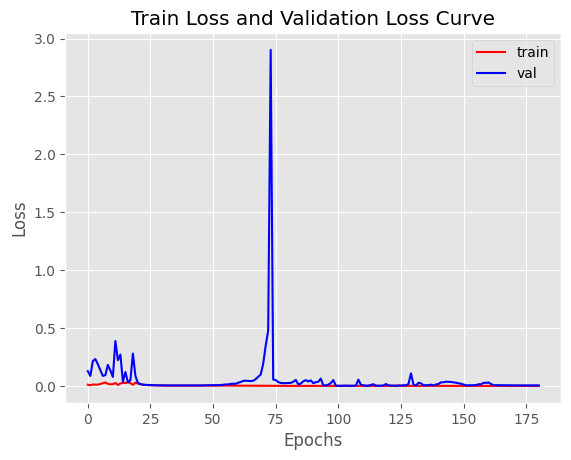

In [27]:
plot_error(train_error, val_error)

#### 6.2. Đánh giá mô hình trên tập test

In [28]:
mse, rmse, mape, r2, true, predicted = evaluate_model_4(model, test, timesteps)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


In [29]:
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('MAPE = {}'.format(mape))
print('R-Squared Score = {}'.format(r2))

MSE = 0.0011348796054511474
RMSE = 0.0336879741963085
MAPE = 0.02675516819411632
R-Squared Score = 0.9170480625833


#### 6.3. Vẽ đồ thị dự đoán vs thực tế

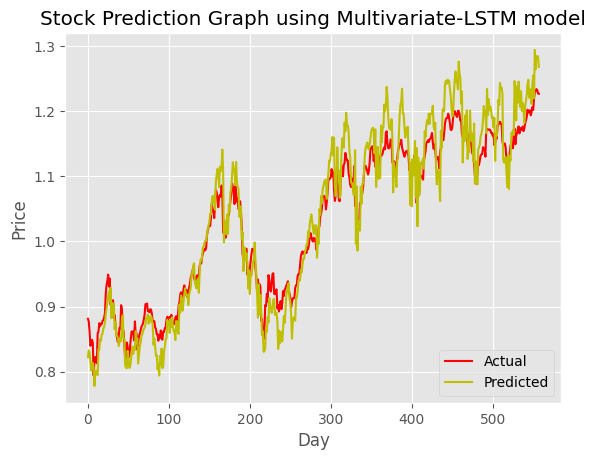

In [30]:
plot_data_4(true, predicted)

In [31]:
# Save a model
model.save('10VAR-VN30index-lstm.keras')

In [ ]:
del model